# Multivariate Time Series Prediction On Cryptocurrency Price

We want to do multivariate price prediction forecasting, so learning price as well as other price action indicators like volume, RSI, etc.

Supporting materials:

* TensorFlow > TensorFlow Core > Tutorials > Advanced > Structured data > [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [ ]:
!pip install yfinance
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00


In [ ]:
from typing import Dict, List, Tuple

from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import requests
import tensorflow as tf
import time
import yfinance as yf

print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.11.0


# 1. Problem Definition

> Given the entire history of a cryptocurrency coin's time series price data, can we accurately predict the price of the coin at the next 7 time steps?

# 2. Data (Yahoo Finance)

Yahoo Finance allows us to retrieve OHLCV data.

In [ ]:
def fetch_yahoo_finance_market_chart(coin_code: str,
                                     vs_currency: str) -> pd.DataFrame:
    ticker = yf.Ticker(f'{coin_code}-{vs_currency}')
    df = ticker.history(period='5y',    # Last 5 years
                        interval='1d',  # Daily data
                        prepost=False,  # Don't fetch pre-post market data
                        keepna=True,    # Whether to let yfinance drop rows with NaN
                        timeout=None,
                        raise_errors=True)

    # Returns pd.DataFrame with columns:
    #   ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
    # 'Dividends' and 'Stock Splits' aren't useful (all 0s in df.describe())
    return df.drop(columns=['Dividends', 'Stock Splits'])

In [ ]:
df = fetch_yahoo_finance_market_chart('BTC', 'USD')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2018-03-23 00:00:00+00:00 to 2023-03-23 00:00:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1827 non-null   float64
 1   High    1827 non-null   float64
 2   Low     1827 non-null   float64
 3   Close   1827 non-null   float64
 4   Volume  1827 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.6 KB


The columns given by the data are:

1. `'Date'`: the timezone-aware `Timestamp` of the entry, set as the `pandas.DatetimeIndex`.
2. `'Open'`: the `float64` value of the coin (BTC) on the day's market opening in the versus currency (USD).
3. `'High'`: the highest `float64` value of the coin during the day's market hours in the versus currency.
4. `'Low'`: the lowest `float64` value of the coin during the day's market hours in the versus currency.
5. `'Close'`: the `float64` value of the coin on the day's market closing in the versus currency.
6. `'Volume'`: the number (`int64`) of trades that occurred for this coin during market hours for this day **(CHECK?)**.

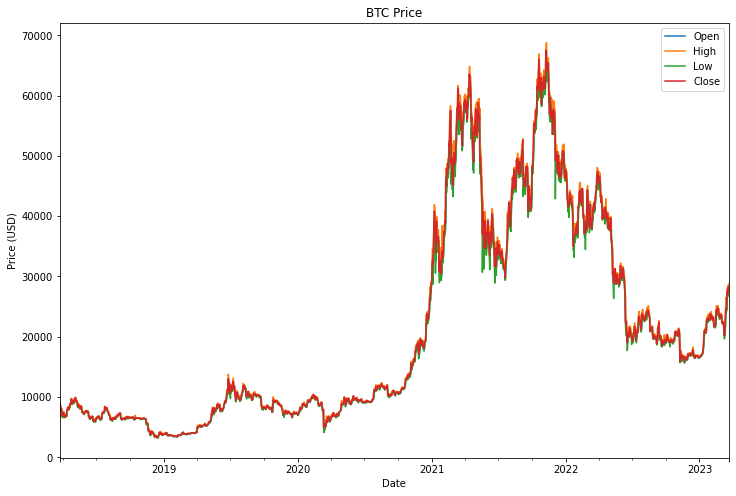

In [ ]:
# plt.figure(figsize=(12,8))
# plt.plot(df)
df[['Open', 'High', 'Low', 'Close']].plot(figsize=(12,8))
plt.title('BTC Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

In [ ]:
# Using plotly library
# https://plotly.com/python/ohlc-charts/
fig = go.Figure(data=go.Ohlc(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close']))
fig.show()

# 3. Quality Criterion For Evaluation

> The model is accurate if we can minimise the MSE (root mean squared error) between the expected and predicted coin price, within a 95% confidence interval.

Choice of loss function for quality criterion (provided by `tf.keras`:

* **MAE (Mean Absolute Error):** $\frac{1}{n}\sum_{i=1}^n{|y_i - \hat{y}_i|}$ - Straightforward, robust to outliers since it doesn't punish them severely.
* **MSE (Mean Squared Error):** $\frac{1}{n}\sum_{i=1}^n{(y_i - \hat{y}_i)^2}$ - Popular, punishes larger errors which is useful in real-world applications.
* **MSLE (Mean Squared Logarithmic Error):** $\frac{1}{n}\sum_{i=1}^n{(\log(y_i) - \log(\hat{y}_i))^2}$ - Used when the model is expected to predict outputs whose underlying distribution is logarithmic.
* **MAPE (Mean Absolute Percentage Error):** $\frac{1}{n}\sum_{i=1}^N{100 \times \frac{y_i - \hat{y}_i}{y_i}}$ - Accuracy for regression.

MSE is used in this notebook, but MAPE is another choice too.

# 4. Data Cleaning

(a.k.a. data pre-processing) The purpose of data cleaning is to pre-process the data before applying any ML-specific pipeline steps like feature engineering, feature encoding, etc.

## Missing Values

In a `pandas.DataFrame`, the null value types and the column types they could be in are:

* `NaN`: integer (e.g. `int64`) , float (e.g. `float64`) or boolean (`bool`).
* `None`: object (`object`, `category`, `string`).
* `NaT` (implicitly `np.NaT`) or `pd.Nat` (pandas equivalent): datetime (e.g. `datetime64` or `timedelta64`).

Strategies for handling missing values:

* **Drop:** Remove rows containing missing values using `pd.DataFrame.dropna()`.
* **Mean imputation:** Replace missing values for a numerical feature column with the feature's mean value.
* **Median imputation:** Replace missing values for a numerical feature column with the feature's median value.
* **Mode imputation:** Replace missing values for a object-type feature column with the feature's mode value.
* **Regression imputation.** If the feature column is associated with a continuous variable, then you can use a regression model to impute msising values.
* **$K$-Nearest Neighbours (KNN) imputation:** Find the $K$ closest rows to the missing value's row and compute from those rows values a value to impute with.

Another way for us is to just use the value that is either exactly between the days that were missing if both are available, or take the last present day's value.

In [ ]:
def clean_yahoo_finance_market_chart(df):
    """
    Clean data from Yahoo Finance by handling missing values.

    :param df: raw Yahoo Finance market chart data in `pandas.DataFrame`.
    :return df: pre-processed Yahoo Finance market chart data.
    """

# 4. Feature Engineering

There's many feature-related steps in an ML pipeline.

1. Feature engineering.
2. Feature extraction.
3. Feature encoding.
4. Feature scaling.
5. Feature selection.
6. Feature combination.

## Inspection & Cleanup

In [ ]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2018-03-23 00:00:00+00:00,8736.250000,8879.620117,8360.620117,8879.620117,5954120192
2018-03-24 00:00:00+00:00,8901.950195,8996.179688,8665.700195,8668.120117,5664600064
2018-03-25 00:00:00+00:00,8612.809570,8682.009766,8449.099609,8495.780273,4569880064
2018-03-26 00:00:00+00:00,8498.469727,8530.080078,7921.430176,8209.400391,5921039872
2018-03-27 00:00:00+00:00,8200.000000,8232.780273,7797.279785,7833.040039,5378250240
...,...,...,...,...,...
2023-03-19 00:00:00+00:00,26969.503906,28440.560547,26907.716797,28038.675781,37769448859
2023-03-20 00:00:00+00:00,28041.601562,28527.724609,27242.880859,27767.236328,44774027664
2023-03-21 00:00:00+00:00,27768.392578,28439.562500,27439.646484,28175.816406,36102192830


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2018-03-23 00:00:00+00:00 to 2023-03-23 00:00:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1827 non-null   float64
 1   High    1827 non-null   float64
 2   Low     1827 non-null   float64
 3   Close   1827 non-null   float64
 4   Volume  1827 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.6 KB


(Scenario when we fetched all CoinGecko BTC vs USD data) There is one row with `NaN` in the `market_caps` column, so we'll drop this row.

In [ ]:
df.describe()

,Open,High,Low,Close,Volume
count,1827.000000,1827.000000,1827.000000,1827.000000,1.827000e+03
mean,20842.802641,21346.312975,20288.825620,20851.196593,2.732993e+10
std,16870.663014,17316.364643,16351.369854,16864.622450,1.956838e+10
min,3236.274658,3275.377930,3191.303467,3236.761719,2.923670e+09
25%,7710.426514,7929.130859,7532.588379,7709.440430,1.475210e+10
50%,11713.306641,11902.335938,11393.374023,11742.037109,2.529378e+10
75%,33767.375000,34778.076172,32265.797852,33734.515625,3.613765e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11


Yahoo Finance tends to provide data that doesn't require processing for missing values.

## Date & Time

The `Date` columns is of type `datetime64[ns]`, meaning that the `Date` is being represented as a time in nanoseconds.

There's many ways to encode date and time:

1. **Cyclical encoding:** If the label features are cyclical or has periodicity, then extract the trigonometric components $\sin(x)$ and $\cos(x)$ from the periodic components of the date like day, month, and year, or the time like hour, minute, and second.
2. **Timestamp encoding:** Leave the `datetime64[ns]` as it is since it's a time in nanoseconds, or you could convert to a Unix timestamp.
3. **One-hot encoding:** Splits the date and time components into binary columns that can be marked true or false for each possible value, e.g. if you want to mark what day of the week it was, you can create 7 columns, `'dayofweek_0', ..., 'dayofweek_6'` and mark the column corresponding to the day of the week it was with `1` and the rest `0`.
5. **Ordinal encoding:** Split the date and time components into integer columns for each property, e.g. `'day', 'month', 'year', 'hour', 'minute', 'second', ...`.

In [ ]:
# df['Date_day'] = df.index.day
# df['Date_month'] = df.index.month
# df['Date_year'] = df.index.year
# df['Date_day_of_week'] = df.index.day_of_week
# df['Date_week_of_year'] = df.index.weekofyear
# df['Date_day_of_year'] = df.index.day_of_year

df

,Open,High,Low,Close,Volume
Date,,,,,
2018-03-23 00:00:00+00:00,8736.250000,8879.620117,8360.620117,8879.620117,5954120192
2018-03-24 00:00:00+00:00,8901.950195,8996.179688,8665.700195,8668.120117,5664600064
2018-03-25 00:00:00+00:00,8612.809570,8682.009766,8449.099609,8495.780273,4569880064
2018-03-26 00:00:00+00:00,8498.469727,8530.080078,7921.430176,8209.400391,5921039872
2018-03-27 00:00:00+00:00,8200.000000,8232.780273,7797.279785,7833.040039,5378250240
...,...,...,...,...,...
2023-03-19 00:00:00+00:00,26969.503906,28440.560547,26907.716797,28038.675781,37769448859
2023-03-20 00:00:00+00:00,28041.601562,28527.724609,27242.880859,27767.236328,44774027664
2023-03-21 00:00:00+00:00,27768.392578,28439.562500,27439.646484,28175.816406,36102192830


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2018-03-23 00:00:00+00:00 to 2023-03-23 00:00:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1827 non-null   float64
 1   High    1827 non-null   float64
 2   Low     1827 non-null   float64
 3   Close   1827 non-null   float64
 4   Volume  1827 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.6 KB


# 5. [Split The Data](https://www.tensorflow.org/tutorials/structured_data/time_series#split_the_data)

We'll use an `80:10:10` percentage (ratio) split for our `training:validation:testing` datasets.

We will **not** shuffle the data **before** splitting it because we are using time series data.

* We need to be able to window the data and we can't do this if it's randomised.
* Our validation and testing results will be more realistic if we train on previously collected data to predict the next data.

The `df` is already ordered since we indexed by `timestamp` which is a `DatetimeIndex`.

In [ ]:
n = len(df)
training_df = df[:int(n * 0.8)]
validation_df = df[int(n * 0.8):int(n * 0.9)]
testing_df = df[int(n * 0.9):]

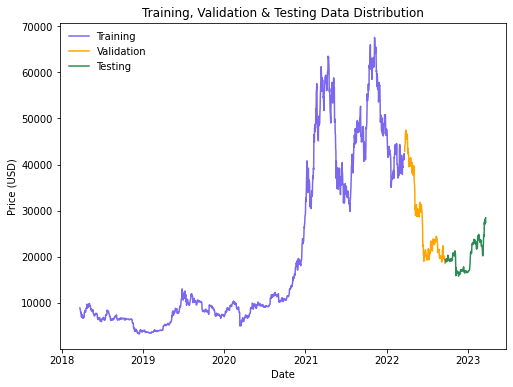

In [ ]:
def plot_data_split(training_df: pd.DataFrame,
                    validation_df: pd.DataFrame,
                    testing_df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.close()  # Closes the figure window when in Jupyter Notebook
    ax.set_title(f'Training, Validation & Testing Data Distribution')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')
    ax.plot(training_df[['Close']], color='mediumslateblue', label='Training')
    ax.plot(validation_df[['Close']], color='orange', label='Validation')
    ax.plot(testing_df[['Close']], color='seagreen', label='Testing')
    _ = ax.legend(loc='upper left', frameon=False)
    return fig


plot_data_split(training_df, validation_df, testing_df)

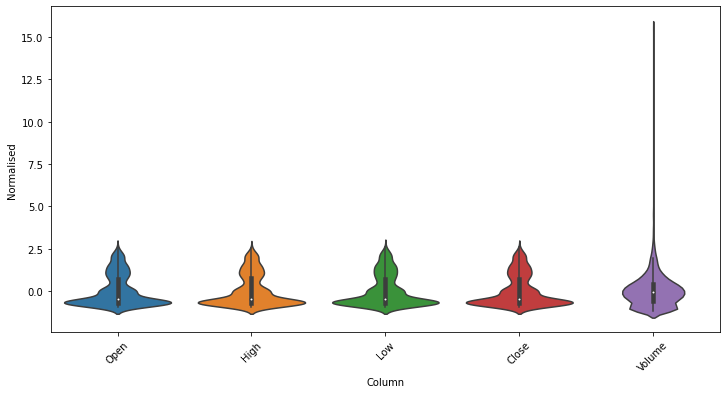

In [ ]:
df_std = (df - training_df.mean()) / training_df.std()
df_std = df_std.melt(var_name='Column', value_name='Normalised')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalised', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=45)

The above is just to check if there's an absurd distribution of features (if there's any glaring outliers) between the training dataset and the entire dataset. It looks like there isn't one so we don't need to do anything.

# 6. [Normalise Data With Continuous, Unknown Or Large-Range Distributions Data](https://www.tensorflow.org/tutorials/structured_data/time_series#normalize_the_data)

It's important to do this step if you have features with large value ranges, otherwise you will get exploding gradients and `NaN` losses when training your model i.e. ["improves the performance and training stability of the model"](https://developers.google.com/machine-learning/data-prep/transform/normalization).

Normalisation techniques for each feature:

* Scaling to a range.
* Clipping.
* $\log$-scaling.
* $z$-scoring.

See Google's ["Machine Learning > Foundational courses > Data Prep > Normalisation"](https://developers.google.com/machine-learning/data-prep/transform/normalization) section to see the formulas, advantages and disadvantages of each technique.

We will use `z`-scoring on each column.

$$
z = \frac{x - \bar{x}}{s}
$$

where $\bar{x}$ is the sample mean and $s$ is the sample standard deviation given by the sample variance

$$
s^2 = \frac{\Sigma (x_i - \bar{x})}{n - 1}
$$

This will scale columns such that they have zero mean $\mu = 0$ and unit variance $\sigma^2 = 1$ (or unit standard deviation $\sigma = 1$)

`scikit-learn`'s scalers, in particular, `sklearn.preprocessing.StandardScaler`, implements per-column $z$-score, however it uses population variance in the transformations (i.e. 0 degrees of freedom)by default.

If we manually normalise the `pandas.DataFrame` using `(df - df.mean() / df.std()`, then we can use the sample variance (i.e. `ddof=1` delta degrees of freedom) as this is `pandas` default for `pd.DataFrame.std()`.

Since we are only looking at the last 5 years of daily data, it's a better idea to use sample variance, so we will create our own scaler.

If we used all the daily data, then we can use `StandardScaler`, because the population we're interested in is price daily data (i.e. collected at midnight every day), not the price at every second/minute/hour, and we would have the entire population.

$z$-score normalisation is only supposed to be applied to continuous variables with a perhaps unknown distribution or large value range, e.g. `'Price'`, `'Market Capitalisation'` and `'Volume'`.

Categorical and discrete variables, like date or time, do not need $z$-score normalisation. You might, however, consider encoding them otherwise e.g. one-hot encoding or ordinal encoding.

The next 4 cells demonstrate how the methods result in different normalised outputs.

In [ ]:
scale_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
continuous_columns_df = training_df[scale_columns]
((continuous_columns_df - continuous_columns_df.mean()) / continuous_columns_df.std()).values

array([[-0.61395126, -0.61741068, -0.62320511, -0.60719238, -0.99138836],
       [-0.60493263, -0.61123447, -0.60605937, -0.61870287, -1.00523137],
       [-0.62066981, -0.62788158, -0.61823249, -0.62808214, -1.05757391],
       ...,
       [ 1.20692717,  1.15033736,  1.21142057,  1.15438618, -0.31368613],
       [ 1.15547836,  1.10864916,  1.19249694,  1.14514361, -0.0991178 ],
       [ 1.14611535,  1.19715418,  1.20824655,  1.21484942,  0.2541824 ]])

`pandas` normalisation using `pd.DataFrame.std(ddof=0)` corresponds to `StandardScaler.var_`.

In [ ]:
((continuous_columns_df - continuous_columns_df.mean()) / continuous_columns_df.std(ddof=0)).values

array([[-0.61416148, -0.61762209, -0.6234185 , -0.60740029, -0.99172781],
       [-0.60513976, -0.61144376, -0.60626689, -0.61891472, -1.00557557],
       [-0.62088233, -0.62809657, -0.61844418, -0.6282972 , -1.05793603],
       ...,
       [ 1.20734043,  1.15073125,  1.21183537,  1.15478145, -0.31379353],
       [ 1.155874  ,  1.10902877,  1.19290526,  1.14553571, -0.09915174],
       [ 1.14650779,  1.1975641 ,  1.20866026,  1.21526539,  0.25426943]])

In [ ]:
scaler = StandardScaler()
scaler.fit_transform(continuous_columns_df)

array([[-0.61416148, -0.61762209, -0.6234185 , -0.60740029, -0.99172781],
       [-0.60513976, -0.61144376, -0.60626689, -0.61891472, -1.00557557],
       [-0.62088233, -0.62809657, -0.61844418, -0.6282972 , -1.05793603],
       ...,
       [ 1.20734043,  1.15073125,  1.21183537,  1.15478145, -0.31379353],
       [ 1.155874  ,  1.10902877,  1.19290526,  1.14553571, -0.09915174],
       [ 1.14650779,  1.1975641 ,  1.20866026,  1.21526539,  0.25426943]])

In [ ]:
continuous_columns_df.std(ddof=0) ** 2, scaler.var_  # np.std(continuous_columns_df.values, axis=0)

(Open      3.373392e+08
 High      3.559215e+08
 Low       3.163866e+08
 Close     3.373928e+08
 Volume    4.371183e+20
 dtype: float64,
 array([3.37339240e+08, 3.55921475e+08, 3.16386618e+08, 3.37392803e+08,
        4.37118347e+20]))

Out of other normalisation techniques (or `sklearn.preprocessing` scalers), $z$-score normalisation is probably the best since:

* Financial data is often normally distributed.
* It is robust to outliers, which is common in financial data.
* $z$-scores preserve the relative distance between data points which is important for interpretting results.

For machine learning, our input and model output may have a different number of columns. This means we need two scalers. One for the (input) window's columns and one for the (output) label columns. 

The scaler for the input and output need to be saved (`pickle`d) with the models.

In [ ]:
class ZScaler:

    def __init__(self,
                 df: pd.DataFrame,
                 scale_columns: List[str] = None,
                 label_columns: List[str] = None):
        """
        :param df: pandas.DataFrame to transform/inverse-transform w.r.t.
        :param label_columns: ordered list of columns that need to be
                              de-normalised from model output tensor.
        """
        self.mean = df.mean()
        self.std = df.std()
        self.scale_columns = scale_columns
        self.scale_column_indices = {name: i
                                     for i, name in enumerate(df.columns)
                                     if name in scale_columns}
        self.label_columns = label_columns

    def transform(self,
                  df: pd.DataFrame) -> np.array:
        """
        Scales the given pandas.DataFrame by calculating z-scores on each column
        with the mean and standard deviation of the training data.

        :param df: pandas.DataFrame to normalise.
        :return: column-wise z-normalised np.array.
        """
        df = df.copy()
        df[self.scale_columns] -= self.mean[self.scale_columns]
        df[self.scale_columns] /= self.std[self.scale_columns]
        return df.values

    def inverse_transform(self,
                          tensor: tf.Tensor,
                          is_input: bool = False) -> np.array:
        """
        Inverse scales the model output w.r.t. the label columns or `columns` if
        given. This is an in-place operation.

        :param outputs: tensor of shape (_, label_steps, label_features)
                        containing model outputs.
        :param is_input: whether the tensor is of the input format so that we
                         scale w.r.t the scale columns instead of label columns.
        """
        if is_input:
            for column_name, i in self.scale_column_indices.items():
                tensor[:, i] *= self.std[column_name]
                tensor[:, i] += self.mean[column_name]
        else:
            for i, label_name in enumerate(self.label_columns):
                # For all outputs in this label column, inverse z-score transform
                # the values.
                tensor[:, i] *= self.std[label_name]
                tensor[:, i] += self.mean[label_name]

In [ ]:
zscaler = ZScaler(training_df,
                  scale_columns=['Open', 'High', 'Low', 'Close', 'Volume'],
                  label_columns=['Close'])
zscaled_training_df = zscaler.transform(training_df)
zscaled_training_df

array([[-0.61395126, -0.61741068, -0.62320511, -0.60719238, -0.99138836],
       [-0.60493263, -0.61123447, -0.60605937, -0.61870287, -1.00523137],
       [-0.62066981, -0.62788158, -0.61823249, -0.62808214, -1.05757391],
       ...,
       [ 1.20692717,  1.15033736,  1.21142057,  1.15438618, -0.31368613],
       [ 1.15547836,  1.10864916,  1.19249694,  1.14514361, -0.0991178 ],
       [ 1.14611535,  1.19715418,  1.20824655,  1.21484942,  0.2541824 ]])

In [ ]:
zscaler.inverse_transform(zscaled_training_df, is_input=True)
zscaled_training_df

array([[8.73625000e+03, 8.87962012e+03, 8.36062012e+03, 8.87962012e+03,
        5.95412019e+09],
       [8.90195020e+03, 8.99617969e+03, 8.66570020e+03, 8.66812012e+03,
        5.66460006e+09],
       [8.61280957e+03, 8.68200977e+03, 8.44909961e+03, 8.49578027e+03,
        4.56988006e+09],
       ...,
       [4.21914062e+04, 4.22411641e+04, 4.10047578e+04, 4.12478242e+04,
        2.01279467e+10],
       [4.12461328e+04, 4.14544102e+04, 4.06680430e+04, 4.10779961e+04,
        2.46155433e+10],
       [4.10741055e+04, 4.31247070e+04, 4.09482812e+04, 4.23588086e+04,
        3.20046524e+10]])

In [ ]:
training_df

,Open,High,Low,Close,Volume
Date,,,,,
2018-03-23 00:00:00+00:00,8736.250000,8879.620117,8360.620117,8879.620117,5954120192
2018-03-24 00:00:00+00:00,8901.950195,8996.179688,8665.700195,8668.120117,5664600064
2018-03-25 00:00:00+00:00,8612.809570,8682.009766,8449.099609,8495.780273,4569880064
2018-03-26 00:00:00+00:00,8498.469727,8530.080078,7921.430176,8209.400391,5921039872
2018-03-27 00:00:00+00:00,8200.000000,8232.780273,7797.279785,7833.040039,5378250240
...,...,...,...,...,...
2022-03-18 00:00:00+00:00,40944.839844,42195.746094,40302.398438,41801.156250,34421564942
2022-03-19 00:00:00+00:00,41794.648438,42316.554688,41602.667969,42190.652344,19664853187
2022-03-20 00:00:00+00:00,42191.406250,42241.164062,41004.757812,41247.824219,20127946682


# 7. [Data Windowing](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing)

We are creating a model that makes predictions given a window of consecutive samples from our dataset.

A window consists of:

* the number of time steps in the input and output windows.
* the time offset between windows (in terms of time steps).
* which features are used in the inputs, labels or both.

We'll create a `WindowGenerator` class so we can reuse it for any data windowing configuration.

In [ ]:
class WindowGenerator:

    """
    Adapted from https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing
    """

    def __init__(self,
                 training_df: pd.DataFrame,
                 validation_df: pd.DataFrame,
                 testing_df: pd.DataFrame,
                 input_steps: int = 14,
                 label_steps: int = 1,
                 offset: int = 1,
                 label_columns: List[str]=None,
                 scale_columns: List[str]=None,
                 batch_size: int = 32,
                 transform: bool = True):
        """
        Adapted from https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets

        :param df: pandas.DataFrame to split into windowed training, validation
                   and testing datasets.
        :param training_split: decimal percentage of `df` rows to allocate for
                               training.
        :param validation_split: decimal percentage of `df` rows after removing
                                 training rows to allocate for validation.
        :param input_steps: number of time steps for the input window.
        :param label_steps: number of time steps for the label window (to
                            generate predictions for).
        :param offset: number of time steps after the input time steps.
        :param label_columns: ordered list of column names to predict and match
                              against the columns of the model output. If None,
                              all columns are predicted.
        :param batch_size: number of (input, label) pairs in a batch.
        :param transform: whether to scale data using z-scores. Only disable
                          for illustrative purposes.
        """
        self.training_df = training_df
        self.validation_df = validation_df
        self.testing_df = testing_df

        # For financial data with columns that have continuous, large-range, or
        # unknown distributions, we should always scale down those columns to
        # reduce the gradient used when updating weights during gradient
        # descent, which ensures stable model training.
        self.zscaler = ZScaler(training_df,
                               scale_columns=scale_columns,
                               label_columns=label_columns)
        self.transform = transform

        # pandas.DataFrame gets converted into Tensors for model training so we
        # need to log column indices.
        self.column_indices = {name: i for i, name
                               in enumerate(training_df.columns)}
        self.label_columns = label_columns
        # model.predict() returns Tensor so need to record label indices.
        if label_columns is not None:
            self.label_column_indices = {name: i for i, name
                                          in enumerate(label_columns)}

        self.input_steps = input_steps
        self.label_steps = label_steps
        self.offset = offset

        self.total_window_size = input_steps + offset

        self.input_slice = slice(0, input_steps)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start_idx = self.total_window_size - self.label_steps
        self.label_slice = slice(self.label_start_idx, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]

        self.batch_size = batch_size

    def __repr__(self):
        return f'Total window size: {self.total_window_size}\n' \
               f'Input step indices: {self.input_indices}\n' \
               f'Label step indices: {self.label_indices}\n' \
               f'Label column names: {self.label_columns}'

    def split_window(self,
                     window: tf.Tensor):
        """
        Splits a batch of windows of time series data into inputs and labels.
        Adapted from https://www.tensorflow.org/tutorials/structured_data/time_series#2_split

        :param window: tensor of shape (batch_size, total_window_size, input_features).
        :return inputs: data with all columns from input time steps.
        :return labels: data with label columns from label time steps.
        """
        # For all batch items, `self.input_slice` time steps are the inputs.
        inputs = window[:, self.input_slice, :]

        # For all batch items, `self.label_slice` time steps are the labels.
        labels = window[:, self.label_slice, :]
        # `labels` should only consist of columns given in `self.label_columns`.
        if self.label_columns is not None:
            # Get the label columns in every window in every batch item and
            # stack them into another tensor.
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name
                               in self.label_columns],
                              axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually to makes `tf.data.Dataset`s easier to inspect.
        inputs.set_shape([None, self.input_steps, None])
        labels.set_shape([None, self.label_steps, None])

        return inputs, labels


    def _make_dataset(self,
                      df: pd.DataFrame) -> tf.data.Dataset:
        """
        Converts a time series pandas.DataFrame to a tensorflow.data.Dataset.
        Adapted from https://www.tensorflow.org/tutorials/structured_data/time_series#4_create_tfdatadatasets

        :param df: pandas.DataFrame containing time series data.
        :return: tf.data.Dataset i.e. shuffled collection of batches, each
                 containing `batch_size` (input, label) pairs.
        """
        # Generate time series data (i.e. generate windows at every time step),
        # split into batches of `batch_size` windows, and shuffle.
        data = self.zscaler.transform(df) if self.transform else df.values
        ds = tf.keras.utils.timeseries_dataset_from_array(data,
                                                          None,
                                                          self.total_window_size,
                                                          sequence_stride=1,
                                                          shuffle=False,
                                                          batch_size=self.batch_size)
        # Split each batch of windows into (inputs, labels) pairs.
        ds = ds.map(self.split_window)
        return ds

    @property
    def training_dataset(self):
        return self._make_dataset(self.training_df)

    @property
    def validation_dataset(self):
        return self._make_dataset(self.validation_df)

    @property
    def testing_dataset(self):
        return self._make_dataset(self.testing_df)

    @property
    def example(self):
        """
        Get and cache an example batch of `(inputs, labels)` for plotting.
        """
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from `self.testing_dataset`
            result = next(iter(self.testing_dataset))
            # Cache it for next time
            self._example = result
        return result

    def plot(self,
             model: tf.keras.Model = None,
             plot_col: str = 'Close',
             max_subplots: int = 3,
             dataset_type: str = 'testing',
             inverse_transform: bool = None):
        """
        Visualises the first sample of however many batches of a dataset as a
        split window.
        Adapted from https://www.tensorflow.org/tutorials/structured_data/time_series#3_plot

        :param model: Reference to the trained tensorflow.keras.Model to plot
                      predictions for comparison.
        :param plot_col: Name of column to plot.
        :param max_subplots: maximum number of subplots (examples) to plot in
                             the figure.
        :param dataset_type: prefix of dataset to plot examples from (default
                             testing)
        :param inverse_transform: whether to inverse transform the model output
                                  so that the plot is against the original
                                  un-normalised scale.
        """
        fig = plt.figure(figsize=(12, 8))
        plt.close()
        plot_col_idx = self.column_indices[plot_col]

        if 'training'.startswith(dataset_type):
            ds = self.training_dataset
        elif 'validation'.startswith(dataset_type):
            ds = self.validation_dataset
        else:
            ds = self.testing_dataset

        max_n = min(max_subplots, len(ds))
        ylabel = f'{plot_col}{"" if inverse_transform or not self.transform else " [normalised]"}'
        for i, (inputs, labels) in enumerate(ds.take(max_n)):
            ax = fig.add_subplot(max_n, 1, i + 1)
            ax.set_ylabel(ylabel)
            plot_inputs = inputs[0, :, plot_col_idx].numpy()
            if self.transform and inverse_transform:
                plot_inputs = plot_inputs[:, tf.newaxis]
                self.zscaler.inverse_transform(plot_inputs)
            ax.plot(self.input_indices,
                    plot_inputs.flatten(),
                    label='Inputs',
                    marker='.',
                    zorder=-10)
            
            if self.label_columns:
                label_col_idx = self.label_column_indices.get(plot_col, None)
            else:
                label_col_idx = plot_col_idx
            
            if label_col_idx is None:
                continue

            labels = labels[0, :, label_col_idx].numpy()
            if self.transform and inverse_transform:
                labels = labels[:, tf.newaxis]
                self.zscaler.inverse_transform(labels)
            ax.scatter(self.label_indices,
                       labels.flatten(),
                       edgecolors='k',
                       label='Labels',
                       c='#2ca02c')
                       # s=64)

            if model is not None:
                prediction = model(inputs)[0]
                if self.transform and inverse_transform:
                    self.zscaler.inverse_transform(prediction)
                ax.scatter(self.label_indices,
                           prediction[:, label_col_idx],
                           marker='X',
                           edgecolors='k',
                           label='Predictions',
                           c='#ff7f0e')
                           # s=64)
            
        ax.legend()
        ax.set_xlabel('Time (days)')

        return fig

In our case, we'll use the features of the previous 14 time steps of data to predict the labels on the next (15th) time step. The label column we are predicting is `Close`.

This corresponds to `input_steps=14`, `offset=1`, and `label_steps=1`. This means each `input` in the batched `inputs` is all the input columns of the last 14 days (including `Close`), and the corresponding `label` in the batched `labels` is the next day's `Close`.

In [ ]:
w_example = WindowGenerator(training_df,
                            validation_df,
                            testing_df,
                            input_steps=14,
                            label_steps=1,
                            offset=1,
                            scale_columns=['Open', 'High', 'Low', 'Close', 'Volume'],
                            label_columns=['Close'],
                            transform=False)
w_example

Total window size: 15
Input step indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label step indices: [14]
Label column names: ['Close']

In [ ]:
w_example.training_dataset.element_spec

(TensorSpec(shape=(None, 14, 5), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))

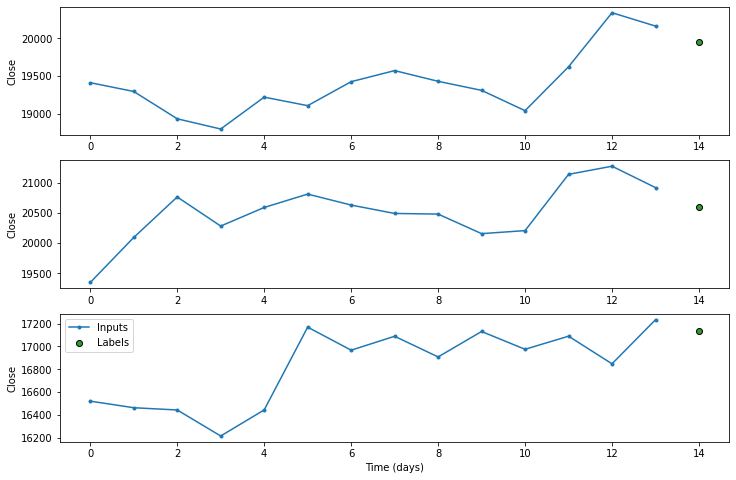

In [ ]:
w_example.plot()

In [ ]:
testing_dataset_iter = iter(w_example.testing_dataset)
testing_inputs, testing_labels = next(testing_dataset_iter)
print(f'inputs shape (batch, timesteps, features): {testing_inputs.shape}')
print(f'labels shape (batch, timesteps, features): {testing_labels.shape}')

inputs shape (batch, timesteps, features): (32, 14, 5)
labels shape (batch, timesteps, features): (32, 1, 1)


The next 3 cells show how the graph plots correspond to the testing dataset. The $n^\text{th}$ plot plots the first split window (at index 0) of the $n^\text{th}$ batch.

In [ ]:
print(testing_inputs[0, :, w_example.column_indices['Close']])
print(testing_labels[0, :, w_example.label_column_indices['Close']])

tf.Tensor(
[19413.55078125 19297.63867188 18937.01171875 18802.09765625
 19222.671875   19110.546875   19426.72070312 19573.05078125
 19431.7890625  19312.09570312 19044.10742188 19623.58007812
 20336.84375    20160.71679688], shape=(14,), dtype=float64)
tf.Tensor([19955.44335938], shape=(1,), dtype=float64)


In [ ]:
testing_inputs, testing_labels = next(testing_dataset_iter)
print(testing_inputs[0, :, w_example.column_indices['Close']])
print(testing_labels[0, :, w_example.label_column_indices['Close']])

tf.Tensor(
[19345.57226562 20095.85742188 20770.44140625 20285.8359375
 20595.3515625  20818.4765625  20635.60351562 20495.7734375
 20485.2734375  20159.50390625 20209.98828125 21147.23046875
 21282.69140625 20926.48632812], shape=(14,), dtype=float64)
tf.Tensor([20602.81640625], shape=(1,), dtype=float64)


In [ ]:
testing_inputs, testing_labels = next(testing_dataset_iter)
print(testing_inputs[0, :, w_example.column_indices['Close']])
print(testing_labels[0, :, w_example.label_column_indices['Close']])

tf.Tensor(
[16521.84179688 16464.28125    16444.62695312 16217.32226562
 16444.98242188 17168.56640625 16967.1328125  17088.66015625
 16908.23632812 17130.48632812 16974.82617188 17089.50390625
 16848.12695312 17233.47460938], shape=(14,), dtype=float64)
tf.Tensor([17133.15234375], shape=(1,), dtype=float64)


In [ ]:
# Illustrating what the tensors looks like VS the original pandas.DataFrame

for training_inputs, training_labels in w_example.training_dataset.take(1):
    print('1st split window:')
    print(training_inputs[0])
    print(training_labels[0])
    print('2nd split window:')
    print(training_inputs[1])
    print(training_labels[1])

training_df.head(16)

1st split window:
tf.Tensor(
[[8.73625000e+03 8.87962012e+03 8.36062012e+03 8.87962012e+03
  5.95412019e+09]
 [8.90195020e+03 8.99617969e+03 8.66570020e+03 8.66812012e+03
  5.66460006e+09]
 [8.61280957e+03 8.68200977e+03 8.44909961e+03 8.49578027e+03
  4.56988006e+09]
 [8.49846973e+03 8.53008008e+03 7.92143018e+03 8.20940039e+03
  5.92103987e+09]
 [8.20000000e+03 8.23278027e+03 7.79727979e+03 7.83304004e+03
  5.37825024e+09]
 [7.83683008e+03 8.12289014e+03 7.80916992e+03 7.95447998e+03
  4.93528986e+09]
 [7.97906982e+03 7.99433008e+03 7.08137988e+03 7.16570020e+03
  6.36122982e+09]
 [7.17145020e+03 7.27666016e+03 6.68393018e+03 6.89052002e+03
  6.28950989e+09]
 [6.89247998e+03 7.20785010e+03 6.86352002e+03 6.97352979e+03
  4.55326976e+09]
 [7.00306006e+03 7.06095020e+03 6.52687012e+03 6.84422998e+03
  4.53210010e+09]
 [6.84485986e+03 7.13547021e+03 6.81658008e+03 7.08379980e+03
  4.33344000e+09]
 [7.10225977e+03 7.53093994e+03 7.07249023e+03 7.45610986e+03
  5.49970022e+09]
 [7.4564101

,Open,High,Low,Close,Volume
Date,,,,,
2018-03-23 00:00:00+00:00,8736.250000,8879.620117,8360.620117,8879.620117,5954120192
2018-03-24 00:00:00+00:00,8901.950195,8996.179688,8665.700195,8668.120117,5664600064
2018-03-25 00:00:00+00:00,8612.809570,8682.009766,8449.099609,8495.780273,4569880064
2018-03-26 00:00:00+00:00,8498.469727,8530.080078,7921.430176,8209.400391,5921039872
2018-03-27 00:00:00+00:00,8200.000000,8232.780273,7797.279785,7833.040039,5378250240
2018-03-28 00:00:00+00:00,7836.830078,8122.890137,7809.169922,7954.479980,4935289856
2018-03-29 00:00:00+00:00,7979.069824,7994.330078,7081.379883,7165.700195,6361229824
2018-03-30 00:00:00+00:00,7171.450195,7276.660156,6683.930176,6890.520020,6289509888
2018-03-31 00:00:00+00:00,6892.479980,7207.850098,6863.520020,6973.529785,4553269760


# 8. Evaluation

## Plotting Functions

In [ ]:
def plot_training_history(history: tf.keras.callbacks.History,
                          model_name: str):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.close()
    ax.plot(history.epoch, history.history['loss'], label='Training Loss')
    ax.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
    ax.set_title(f'{model_name} Training VS Validation Loss')
    ax.set_ylabel('MSE')
    ax.set_xlabel('Epoch')
    _ = ax.legend()  # loc='upper right'
    return fig


def plot_training_histories(model_histories: Dict[str, tf.keras.callbacks.History],
                            training: bool = True,
                            validation: bool = True):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.close()
    # colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = plt.cm.jet(np.linspace(0, 1, len(model_histories)))
    for i, (model_name, history) in enumerate(model_histories.items()):
            if validation:
                ax.plot(history.history['val_loss'],
                        color=colors[i],
                        label=f'{model_name} Validation Loss')
            if training:
                ax.plot(history.history['loss'],
                        color=colors[i],
                        linestyle='--',
                        label=f'{model_name} Training Loss')
    title = []
    if training:
        title.append('Training')
    if validation:
        title.append('Validation')
    ax.set_title(f'{" & ".join(title)} Loss Comparison')
    ax.set_ylabel('MSE')
    ax.set_xlabel('Epoch')
    _ = ax.legend() # loc='upper right'
    return fig   

In [ ]:
def plot_training_time(model_histories: Dict[str, tf.keras.callbacks.History]):
    x = np.arange(len(model_histories))
    width = 0.75

    fig, ax = plt.subplots(figsize=(12, 8))
    plt.close()
    times = [history.training_time for history in model_histories.values()]
    ax.bar(x, times, width, color='mediumslateblue') # , width

    ax.set_title('Training Time')
    ax.set_xticks(x,
                  labels=model_histories.keys(),
                  rotation=45)
    ax.set_ylabel('Time (seconds)')

    return fig

In [ ]:
def plot_performance(validation_performance: Dict,
                     testing_performance: Dict,
                     training_performance: Dict = None):
    n = len(testing_performance)
    x = np.arange(n)
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 8))
    plt.close()
    if training_performance:
        ax.bar(x - 0.27, training_performance.values(), width, label='Training')
    ax.bar(x, validation_performance.values(), width, label='Validation')
    ax.bar(x + 0.27, testing_performance.values(), width, label='Testing')

    ax.set_title(f'{"" if not training_performance else "Training,"}'
                 f'Validation & Testing Performance')
    ax.set_xticks(ticks=x if training_performance else (x + width / 2),
                  labels=testing_performance.keys(),
                  rotation=45)
    ax.set_ylabel(f'MSE (average over all times and outputs)')
    _ = ax.legend()

    return fig

# 9. Modelling Using TensorFlow

We want to compile and fit all the models similarly so let's define a function to do this.

In [ ]:
MAX_EPOCHS = 100
MAX_PATIENCE = 3
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
SHUFFLE = True

def compile_and_fit(model: tf.keras.Model,
                    wg: WindowGenerator,
                    epochs: int = MAX_EPOCHS,
                    patience: int = MAX_PATIENCE,
                    learning_rate: float = LEARNING_RATE,
                    shuffle: bool = SHUFFLE) -> tf.keras.callbacks.History:
    """
    Performs model compilation and fitting for the given model.

    :param model: tf.keras.Model to compile and fit to the training data.
    :param wg: WindowGenerator from which the training dataset is used for
               fitting.
    :param epochs: the number of epochs to train the model on the training and
                   validation data.
    :param patience: number of epochs to determine early stopping.
    :param learning_rate: learning rate to use for the optimizer.
    :param shuffle: whether to shuffle the batches before fitting the model.
    :return: tf.keras.callbacks.History from model.fit() on training dataset.
    """

    # metrics=[tf.keras.metrics.MeanAbsoluteError()]
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.MeanSquaredError()) 
    
    # Regularisation methods to prevent overfitting.
    # Early stopping to prevent over-fitting, and restore the best weights when
    # returning the model.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True)

    t = time.perf_counter()
    history =  model.fit(wg.training_dataset,
                         epochs=epochs,
                         validation_data=wg.validation_dataset,
                         callbacks=[early_stopping])
    t = time.perf_counter() - t
    history.training_time = t
    
    return history

In [ ]:
# Variables used for all models in all model types
INPUT_STEPS = 14
N_FEATURES = len(training_df.columns)
SCALE_COLUMNS = ['Open', 'High', 'Low', 'Close', 'Volume']
LABEL_COLUMNS = ['Close']
CONV_STEPS = 14

## [Single-Step](https://www.tensorflow.org/tutorials/structured_data/time_series#single_step_models) (Single-Output) Modelling

The aim of a single-step model is to predict a single time step ahead of the input window.

We'll create a window generator that uses the last 2 weeks of daily data to predict the next day's closing price. This will generate single-step single-output models.

In [ ]:
SS_INPUT_STEPS = 1
SS_LABEL_STEPS = 1
SS_OFFSET = 1

# Single-step window for evaluating models that rely on the last time step (t-1)
# only. Used for training and evaluation.
ssw = WindowGenerator(training_df,
                      validation_df,
                      testing_df,
                      input_steps=SS_INPUT_STEPS,
                      label_steps=SS_LABEL_STEPS,
                      offset=SS_OFFSET,
                      scale_columns=SCALE_COLUMNS,
                      label_columns=LABEL_COLUMNS)

inputs, labels = ssw.example
print('Inputs shape:', inputs.shape)
print('Labels shape:', labels.shape)
ssw

Inputs shape: (32, 1, 5)
Labels shape: (32, 1, 1)


Total window size: 2
Input step indices: [0]
Label step indices: [1]
Label column names: ['Close']

In [ ]:
# Using > 1 label steps doesn't affect the way the single-step (t-1) models
# operate because it still makes predictions 1 time step ahead based on a single
# input time step.

# Wide window for plotting.
ww = WindowGenerator(training_df,
                     validation_df,
                     testing_df,
                     input_steps=INPUT_STEPS * 5,
                     label_steps=INPUT_STEPS * 5,
                     # label_steps=INPUT_STEPS * 4 + 1,
                     offset=SS_OFFSET,
                     scale_columns=SCALE_COLUMNS,
                     label_columns=LABEL_COLUMNS)

inputs, labels = ww.example
print('Inputs shape:', inputs.shape)
print('Labels shape:', labels.shape)
ww

Inputs shape: (32, 70, 5)
Labels shape: (32, 70, 1)


Total window size: 71
Input step indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Label step indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]
Label column names: ['Close']

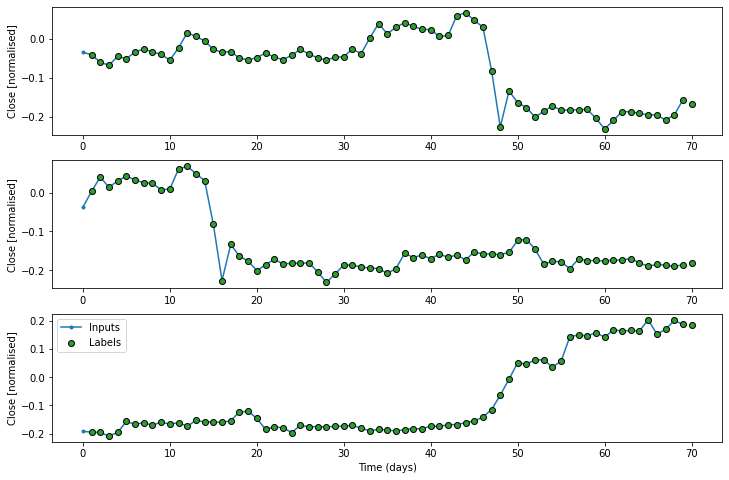

In [ ]:
ww.plot()

We will compare the training, validation and testing datasets' performance on each model as well as plot the training progress.

In [ ]:
ss_model_histories = dict()
ss_training_performance = dict()
ss_validation_performance = dict()
ss_testing_performance = dict()

### Single-Input-Step Baseline (Last Input Time Step Label)

#### Model Construction

In [ ]:
class SSLastBaseline(tf.keras.Model):

    def __init__(self,
                 *args,
                 label_index=None,
                 **kwargs):
        super(SSLastBaseline, self).__init__(*args,
                                             **kwargs)
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        outputs = inputs[:, :, self.label_index]
        return outputs[:, tf.newaxis, tf.newaxis]


ss_baseline = SSLastBaseline(label_index=ssw.column_indices[LABEL_COLUMNS[0]])
ss_baseline.model_name = 'SS Last Baseline'

#### Training (Not Really)

There's no layers so it's not really a model so when you compile and fit it, it will stop early after the `patience`-th epoch as the training and validation losses stay constant.

In [ ]:
ss_baseline.compile(loss=tf.keras.losses.MeanSquaredError())
ss_baseline.build(input_shape=(None, INPUT_STEPS, N_FEATURES))
ss_baseline.summary()

Model: "ss_last_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

The baseline model just shifts the graph forwards by 1 time step.

6/6 [==============================] - 0s 6ms/step - loss: 0.0010


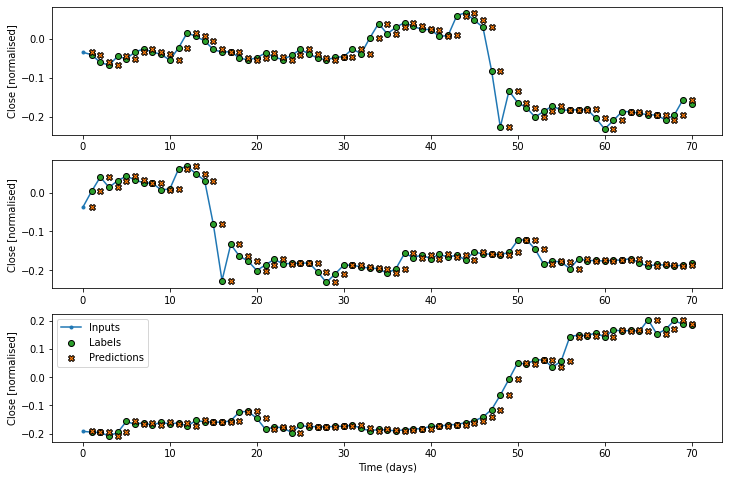

In [ ]:
ss_training_performance[ss_baseline.model_name] = ss_baseline.evaluate(ssw.training_dataset)
ss_validation_performance[ss_baseline.model_name] = ss_baseline.evaluate(ssw.validation_dataset)
ss_testing_performance[ss_baseline.model_name] = ss_baseline.evaluate(ssw.testing_dataset)
ww.plot(model=ss_baseline)

### [Single-Input-Step Linear Model](https://www.tensorflow.org/tutorials/structured_data/time_series#linear)

A linear model is one that performs a linear transformation on the input for the output.

If we use the single-step window that uses `input_steps=1`, this will produce a model that relies on the previous time step only.

A single dense layer (with default `activation='linear'`) creates a linear model i.e. a linear combination of the inputs in the last axis of the layer.

This would be a linear combination of the values in the data's columns `'Open'`, `'High'`, `'Low'`, `'Close'` and `'Volume'`.

If you modify the activation function of the layer, e.g. `'relu'`, `'sigmoid'`, `'tanh'`, etc., then the neural network will be a non-linear function of the inputs.

Therefore linearity/non-linearity of a neural network with a single dense layer depends on the activation function of that layer.

We want a linear model, so we don't explicitly declare an activation.

#### Model Construction

In [ ]:
ss_linear = tf.keras.Sequential([
    # (batches, input_steps, input_features)
    tf.keras.layers.Dense(1)
    # => (batches, input_steps, 1)
])
ss_linear.model_name = 'SS Linear NN'

#### Training

Epoch 1/100
46/46 [==============================] - 2s 18ms/step - loss: 0.1590 - val_loss: 0.0485
Epoch 2/100
46/46 [==============================] - 0s 10ms/step - loss: 0.1355 - val_loss: 0.0471
Epoch 3/100
46/46 [==============================] - 0s 8ms/step - loss: 0.1230 - val_loss: 0.0445
Epoch 4/100
46/46 [==============================] - 1s 11ms/step - loss: 0.1125 - val_loss: 0.0414
Epoch 5/100
46/46 [==============================] - 1s 11ms/step - loss: 0.1029 - val_loss: 0.0381
Epoch 6/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0941 - val_loss: 0.0349
Epoch 7/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0860 - val_loss: 0.0318
Epoch 8/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0784 - val_loss: 0.0289
Epoch 9/100
46/46 [==============================] - 1s 12ms/step - loss: 0.0714 - val_loss: 0.0262
Epoch 10/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0649 - val_loss: 0.0238


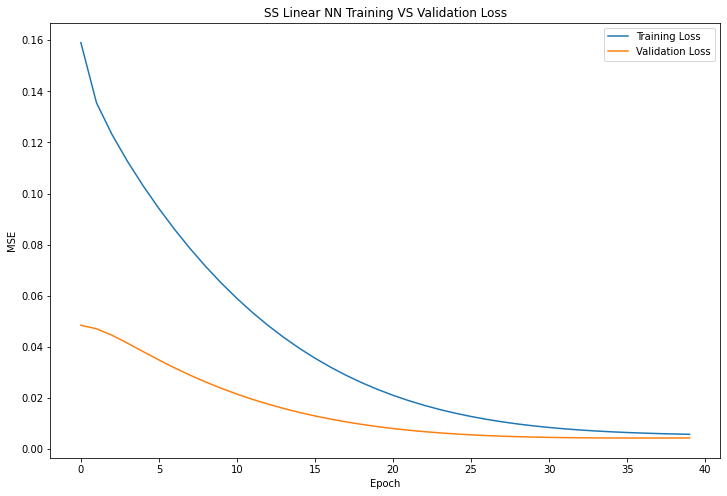

In [ ]:
ss_linear_history = compile_and_fit(ss_linear, ssw)
ss_model_histories[ss_linear.model_name] = ss_linear_history
plot_training_history(ss_linear_history, ss_linear.model_name)

In [ ]:
ss_linear.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 1)              6         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

6/6 [==============================] - 0s 5ms/step - loss: 0.0020


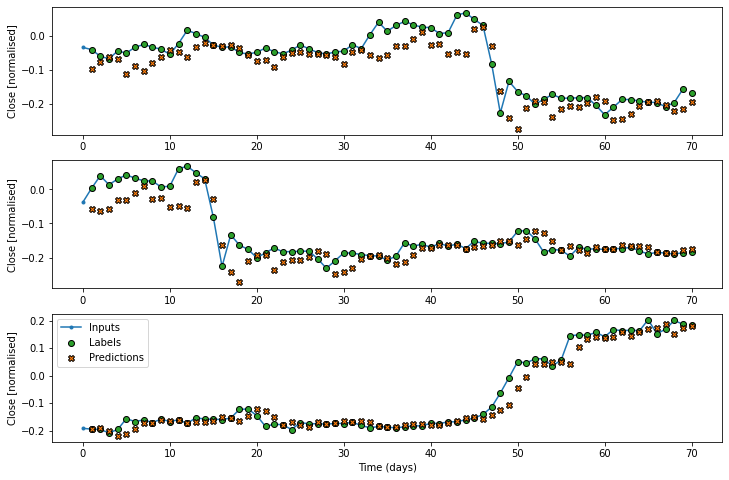

In [ ]:
ss_training_performance[ss_linear.model_name] = ss_linear.evaluate(ssw.training_dataset)
ss_validation_performance[ss_linear.model_name] = ss_linear.evaluate(ssw.validation_dataset)
ss_testing_performance[ss_linear.model_name] = ss_linear.evaluate(ssw.testing_dataset)
ww.plot(model=ss_linear)

You can also visualise the layer weights for linear models, because they're easy to interpret.

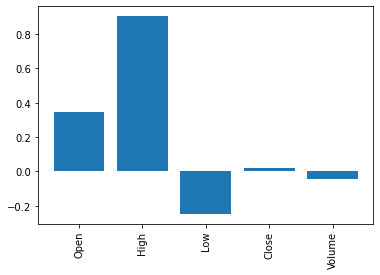

In [ ]:
plt.bar(x=range(len(ssw.training_df.columns)),
        height=ss_linear.layers[0].kernel[:, 0].numpy())
ax = plt.gca()
ax.set_xticks(range(len(ssw.training_df.columns)))
_ = ax.set_xticklabels(ssw.training_df.columns,
                       rotation=90)

### [Single-Input-Step Dense Model](https://www.tensorflow.org/tutorials/structured_data/time_series#dense)

Still relies on the previous time step only, but is more powerful than a linear model.

This dense model consists of multiple hidden dense layers to form a deep neural network (DNN).

#### Model Construction


ReLU (rectified linear unit) activation is an activation function that introduces non-linearity to a DNN.

$$
f(x)=\text{ReLU}(x)=\begin{cases}
0 & x \leq 0 \\
x & x \gt 0
\end{cases}
$$

In [ ]:
ss_dense = tf.keras.Sequential([
    # (batch_size, input_steps, input_features)
    tf.keras.layers.Dense(64,
                          activation='relu'),
    # => (batch_size, input_steps, 64)
    tf.keras.layers.Dense(64,
                          activation='relu'),
    # => (batch_size, input_steps, 64)
    tf.keras.layers.Dense(units=1)
    # => (batch_size, input_steps, 1)
])
ss_dense.model_name = 'SS Dense DNN'

#### Training

Epoch 1/100
46/46 [==============================] - 2s 10ms/step - loss: 0.6738 - val_loss: 0.0647
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0149 - val_loss: 0.0059
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0071
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0047
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0068
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0054
Epoch 9/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0058


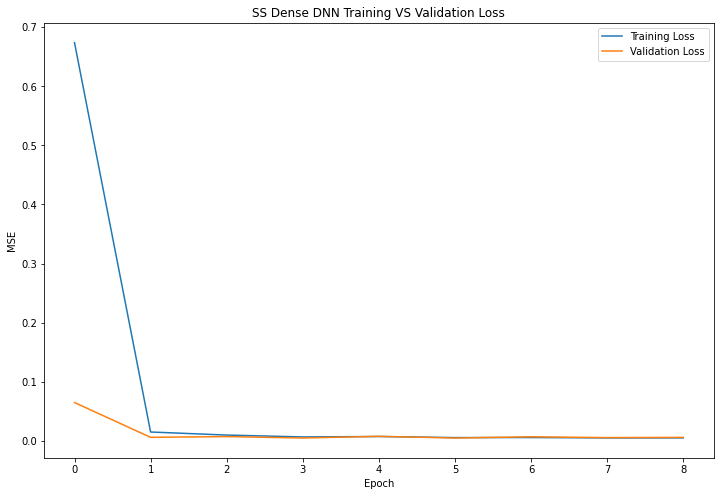

In [ ]:
ss_dense_history = compile_and_fit(ss_dense, ssw)
ss_model_histories[ss_dense.model_name] = ss_dense_history
plot_training_history(ss_dense_history, ss_dense.model_name)

In [ ]:
ss_dense.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1, 64)             384       
                                                                 
 dense_2 (Dense)             (None, 1, 64)             4160      
                                                                 
 dense_3 (Dense)             (None, 1, 1)              65        
                                                                 
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

6/6 [==============================] - 0s 4ms/step - loss: 0.0033


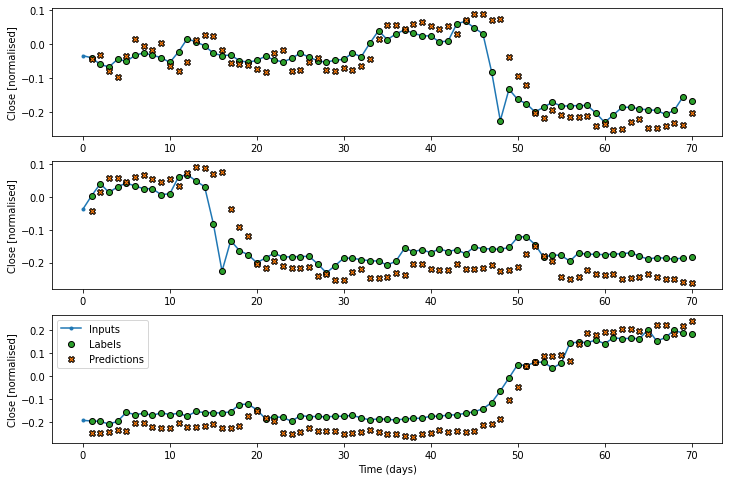

In [ ]:
ss_training_performance[ss_dense.model_name] = ss_dense.evaluate(ssw.training_dataset)
ss_validation_performance[ss_dense.model_name] = ss_dense.evaluate(ssw.validation_dataset)
ss_testing_performance[ss_dense.model_name] = ss_dense.evaluate(ssw.testing_dataset)
ww.plot(model=ss_dense)

### Multi-Input-Step Dense

A single-input-step model can't learn how the input features of the input time steps change over time. We need to give the model multiple input time steps to make a prediction.

In [ ]:
# Convolution window where the last 3 time steps are the input steps, to predict
# the next (4th) time step. Used for training and evaluation.
cw = WindowGenerator(training_df,
                     validation_df,
                     testing_df,
                     input_steps=CONV_STEPS,
                     label_steps=SS_LABEL_STEPS,
                     offset=1,
                     scale_columns=SCALE_COLUMNS,
                     label_columns=LABEL_COLUMNS)

inputs, labels = cw.example
print('Inputs shape:', inputs.shape)
print('Labels shape:', labels.shape)
cw

Inputs shape: (32, 14, 5)
Labels shape: (32, 1, 1)


Total window size: 15
Input step indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label step indices: [14]
Label column names: ['Close']

In [ ]:
# Wide convolution window for plotting.
wcw = WindowGenerator(training_df,
                      validation_df,
                      testing_df,
                      input_steps=INPUT_STEPS * 5 + (CONV_STEPS - 1),
                      label_steps=INPUT_STEPS * 5,
                      offset=1,
                      scale_columns=SCALE_COLUMNS,
                      label_columns=LABEL_COLUMNS)

inputs, labels = wcw.example
print('Inputs shape:', inputs.shape)
print('Labels shape:', labels.shape)
wcw

Inputs shape: (32, 83, 5)
Labels shape: (32, 70, 1)


Total window size: 84
Input step indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
Label step indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83]
Label column names: ['Close']

#### Model Construction

We could handle having many input time steps by flattening the input and adding many dense layers.

In [ ]:
ss_multi_dense = tf.keras.Sequential([
    # (batch_size, input_steps, input_features)
    tf.keras.layers.Flatten(),
    # => (batch_size, input_steps * input_features)
    tf.keras.layers.Dense(32,
                          activation='relu'),
    # => (batch_size, 32)
    tf.keras.layers.Dense(32,
                          activation='relu'),
    # => (batch_size, 32)
    tf.keras.layers.Dense(1),
    # => (batch_size, 1)
    # Add time step dimension back.
    tf.keras.layers.Reshape([1, -1])
    # => (batch_size, 1, 1)
])
ss_multi_dense.model_name = 'SS Multi-Input-Step Dense'

#### Training

Epoch 1/100
46/46 [==============================] - 1s 8ms/step - loss: 0.6794 - val_loss: 0.0823
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: 0.3685 - val_loss: 0.0240
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: 0.2042 - val_loss: 0.0268
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0556 - val_loss: 0.0300
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0514 - val_loss: 0.0343


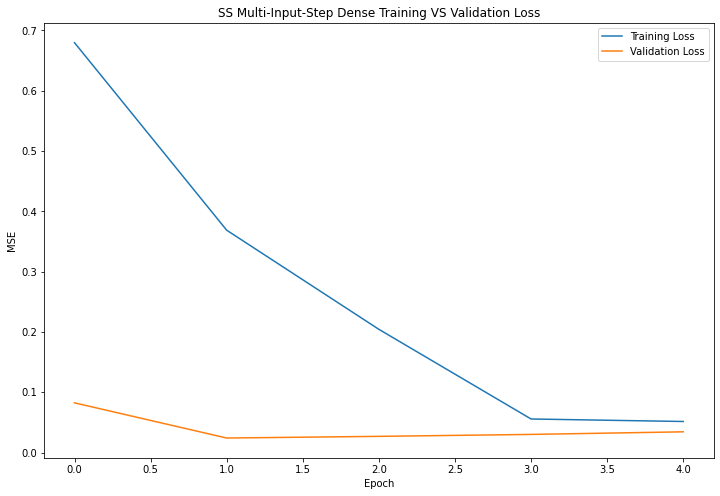

In [ ]:
ss_multi_dense_history = compile_and_fit(ss_multi_dense, cw)
ss_model_histories[ss_multi_dense.model_name] = ss_multi_dense_history
plot_training_history(ss_multi_dense_history, ss_multi_dense.model_name)

In [ ]:
ss_multi_dense.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 70)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2272      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
 reshape (Reshape)           (None, 1, 1)              0         
                                                                 
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

6/6 [==============================] - 0s 6ms/step - loss: 0.0434


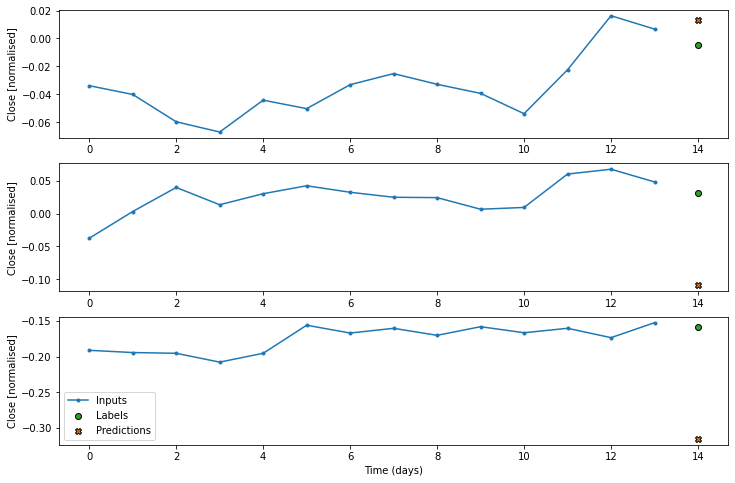

In [ ]:
ss_training_performance[ss_multi_dense.model_name] = ss_multi_dense.evaluate(cw.training_dataset)
ss_validation_performance[ss_multi_dense.model_name] = ss_multi_dense.evaluate(cw.validation_dataset)
ss_testing_performance[ss_multi_dense.model_name] = ss_multi_dense.evaluate(cw.testing_dataset)
cw.plot(model=ss_multi_dense)

The drawback of the multi-input dense model is that it can only be executed on input windows of exactly the shape it was trained on (hence why we can't plot it on a wider input window).

In [ ]:
inputs, labels = ww.example
print('Wide window inputs shape:', inputs.shape)
print('Wide window labels shape:', labels.shape)
try:
    print('Output shape:', ss_multi_dense(inputs).shape)
except Exception as e:
    print(f'\n{type(e).__name__}: {e}')

Wide window inputs shape: (32, 70, 5)
Wide window labels shape: (32, 70, 1)

ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 70, but received input with shape (32, 350)

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 70, 5), dtype=float64)
  • training=None
  • mask=None


### [Temporal 1D-CNN](https://www.tensorflow.org/tutorials/structured_data/time_series#cnn)

A CNN makes predictions based on a fixed-width window of past time steps, so it can learn how features change over time, and potentially perform better than models that only use the previous time step.

In TensorFlow, the 1D convolutional layer is `tf.keras.layers.Conv1D`. `Conv1D` takes two parameters, `filters` and `kernel_size`.

* `filters` specifies the number of output filters (channels) in the last axis of the tensor.
* `kernel_size` specifies the shape of the sliding convolutional window. If we use a 1D convolutional layer, the window must slide along one dimension of the input tensor.

In our case, `kernel_size` would be `(CONV_STEPS,)` which means it will slide a window of length `CONV_STEPS` along the second dimension (corresponding to time steps) of the tensor, and the implicit `None` in the second dimension of `kernel_size` implies to catch all the input columns in this window.

Since the window slides along the length of the dimension, the output tensor will be smaller in the second dimension (time steps) by `CONV_WIDTH - 1`.

#### Model Construction

Same implementation as a multi-input-step dense model but instead:

* The first two layers, `tf.keras.layers.Flatten` and `tf.keras.layers.Dense` are replaced with a convolution, given by `tf.keras.layers.Conv1D`.
* The last layer, `tf.keras.layers.Reshape` is omitted since the convolution allows us to keep the time step axis of the tensor in the output.

In [ ]:
ss_cnn = tf.keras.Sequential([
    # (batch_size, input_steps, input_features)
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_STEPS,),
                           activation='relu'),
    # => (batch_size, input_steps - (CONV_STEPS - 1), 32)
    tf.keras.layers.Dense(32,
                          activation='relu'),
    # => (batch_size, input_steps - CONV_STEPS + 1, 32)
    tf.keras.layers.Dense(1),
    # => (batch_size, input_steps - CONV_STEPS + 1, 1)
])
ss_cnn.model_name = 'SS 1D-CNN'

#### Training

Epoch 1/100
46/46 [==============================] - 2s 11ms/step - loss: 0.3716 - val_loss: 0.1279
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: 0.2849 - val_loss: 0.0320
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0784 - val_loss: 0.0417
Epoch 4/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0623 - val_loss: 0.0127
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0269 - val_loss: 0.0231
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0170 - val_loss: 0.0198
Epoch 7/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0156 - val_loss: 0.0196


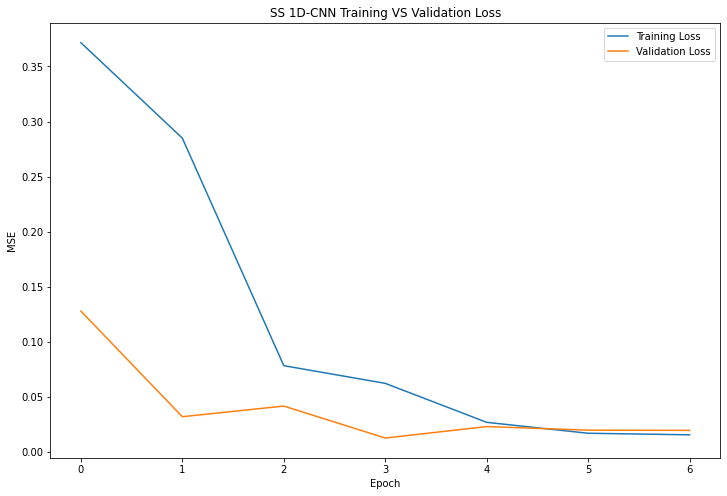

In [ ]:
ss_cnn_history = compile_and_fit(ss_cnn, cw)
ss_model_histories[ss_cnn.model_name] = ss_cnn_history
plot_training_history(ss_cnn_history, ss_cnn.model_name)

In [ ]:
ss_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 32)             2272      
                                                                 
 dense_7 (Dense)             (None, 1, 32)             1056      
                                                                 
 dense_8 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

6/6 [==============================] - 0s 5ms/step - loss: 0.0128


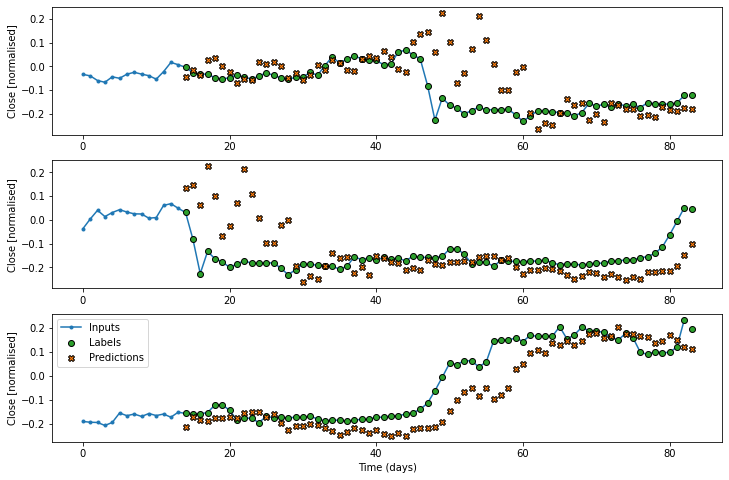

In [ ]:
ss_training_performance[ss_cnn.model_name] = ss_cnn.evaluate(cw.training_dataset)
ss_validation_performance[ss_cnn.model_name] = ss_cnn.evaluate(cw.validation_dataset)
ss_testing_performance[ss_cnn.model_name] = ss_cnn.evaluate(cw.testing_dataset)
wcw.plot(model=ss_cnn)

### [LSTM RNN](https://www.tensorflow.org/tutorials/structured_data/time_series#rnn_2)

All the networks so far (Linear NN, Dense DNN and CNN) are feedforward neural networks meaning that all outputs from each layer move forwards to the next layer only.

Recurrent neural networks (RNNs) are a class of ANNs where there are neurons associated with memory units, and these neurons can have feedback connections, so that the outputs can be fed back into the network for the next time step.

The property of neurons having memory and feedback connections on RNNs make them good for processing sequential data like time series, speech, text, video, etc. since they maintain an internal state.

The way this internal state gets mutated depends on the type of RNN cell chosen. In this section, we use LSTM cells, and in the next, we use GRU cells.

`tf.keras.layers` provides the following:

* `tf.keras.layers.RNN`: a neural network layer where the output of each neuron is fed back into the network as part of the input at the next time step. It takes an RNN `Cell` class layer to create a recurrent neural network layer that can process an arbitrary number of input steps of time series data.
* `tf.keras.layers.LSTMCell`: the LSTM cell layer that processes a single step of an arbitrary length time series input and updates the state of the cell.
* `tf.keras.layers.LSTM`: Equivalent to initialising `tf.keras.layers.RNN` intialised with an `tf.keras.layers.LSTMCell` layer so that it can process an arbitrary number of input time steps.
* `tf.keras.layers.GRUCell` and `tf.keras.layers.GRU` are self-explanatory now.

Long Short-Term Memory is an RNN that uses LSTM cells as the memory units.

#### Model Construction

We'll build a model that predicts the next time step in sequence, using:

* the current time step's input.
* the RNN's internal state (memory) after processing the previous time step in the sequence.

This requires enabling `return_sequences=True`.

See time series forecasting tutorial section ["Recurrent neural network"](https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network) on when to set `return_sequences` to `True` or `False` and for the diagrams.

1. [`LSTM(32, return_sequences=True)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): `return_sequences` is set to `True`, so the model can learn from `INPUT_STEPS` time steps worth of data at a time.
2. [`Dense(1)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): 1 since we only want one value for the output (the next price).

In [ ]:
ss_lstm = tf.keras.Sequential([
    # (batch_size, time_steps, input_features)
    tf.keras.layers.LSTM(32,
                         return_sequences=True),
    # => (batch_size, time_steps, lstm_units)
    tf.keras.layers.Dense(1),
    # => (batch_size, time_steps, 1)
])
ss_lstm.model_name = 'SS LSTM RNN'

# ss_stacked_lstm = tf.keras.Sequential([
#     # Based on: https://ieeexplore.ieee.org/document/9848887
#     # (batch_size, time_steps, input_features) 
#     tf.keras.layers.LSTM(50,
#                          dropout=0.1,
#                          return_sequences=True),
#     # => (batch_size, time_steps, lstm_units)
#     tf.keras.layers.LSTM(50,
#                          dropout=0.1,
#                          return_sequences=True),
#     # => (batch_size, time_steps, lstm_units)
#     tf.keras.layers.LSTM(50,
#                          dropout=0.1,
#                          return_sequences=True),
#     # => (batch_size, time_steps, lstm_units)
#     tf.keras.layers.LSTM(50,
#                          dropout=0.1,
#                          return_sequences=False),
#     # => (batch_size, lstm_units)
#     tf.keras.layers.Dense(units=1)
#     # => (batch_size, time_steps, label_features)
# ])
# ss_stacked_lstm.model_name = 'SS Stacked LSTM RNN'

#### Training

Since we designed the LSTM RNN on a single LSTM layer to return sequences for each window, it will return an output for each input. This means we need to train it using the wide single-step window where `input_steps=output_steps` and `offset=1`.

Epoch 1/100
44/44 [==============================] - 5s 54ms/step - loss: 0.1872 - val_loss: 0.2189
Epoch 2/100
44/44 [==============================] - 1s 34ms/step - loss: 0.1371 - val_loss: 0.0270
Epoch 3/100
44/44 [==============================] - 1s 34ms/step - loss: 0.0644 - val_loss: 0.0609
Epoch 4/100
44/44 [==============================] - 1s 34ms/step - loss: 0.0320 - val_loss: 0.0273
Epoch 5/100
44/44 [==============================] - 2s 34ms/step - loss: 0.0246 - val_loss: 0.0289


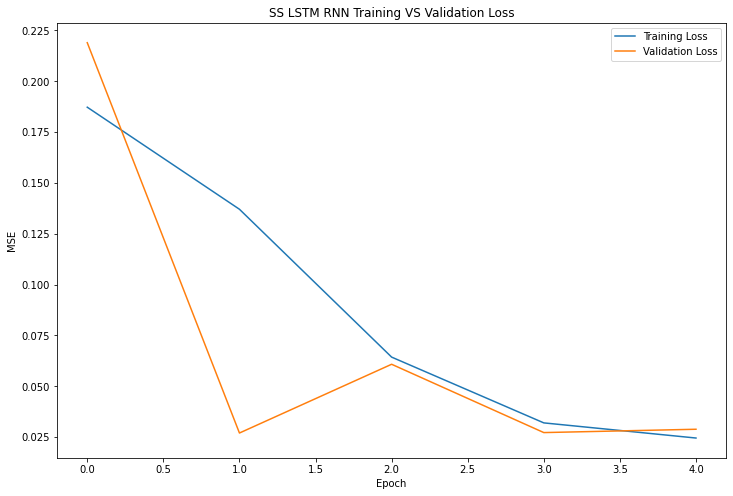

In [ ]:
ss_lstm_history = compile_and_fit(ss_lstm, ww)
ss_model_histories[ss_lstm.model_name] = ss_lstm_history
plot_training_history(ss_lstm_history, ss_lstm.model_name)

In [ ]:
ss_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70, 32)            4864      
                                                                 
 dense_9 (Dense)             (None, 70, 1)             33        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

On the first time steps, the model has no access to previous time steps and therefore it's internal state hasn't been "warmed up". This means it probably won't perform better than the linear and dense models from earlier

4/4 [==============================] - 0s 12ms/step - loss: 0.0055


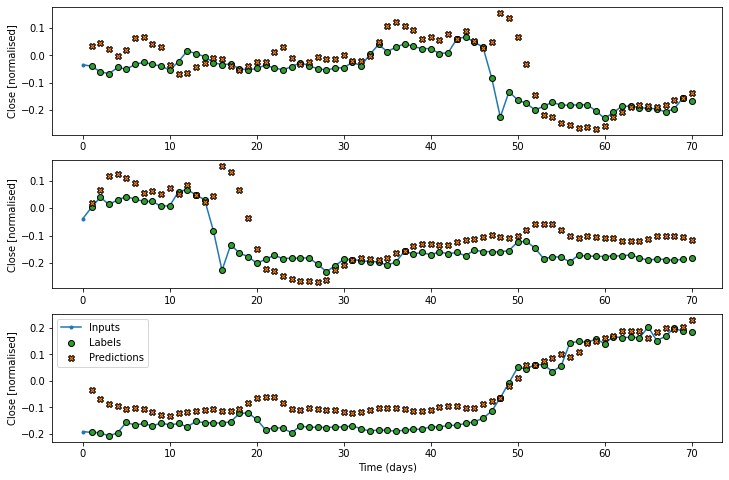

In [ ]:
ss_training_performance[ss_lstm.model_name] = ss_lstm.evaluate(ww.training_dataset)
ss_validation_performance[ss_lstm.model_name] = ss_lstm.evaluate(ww.validation_dataset)
ss_testing_performance[ss_lstm.model_name] = ss_lstm.evaluate(ww.testing_dataset)
ww.plot(model=ss_lstm)

### [GRU RNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)

#### Model Construction

In [ ]:
ss_gru = tf.keras.Sequential([
    # (batch_size, time_steps, input_features)
    tf.keras.layers.LSTM(32,
                         return_sequences=True),
    # => (batch_size, time_steps, gru_units)
    tf.keras.layers.Dense(1),
    # => (batch_size, time_steps, 1)
])
ss_gru.model_name = 'SS GRU RNN'

# ss_stacked_gru = tf.keras.Sequential([
#     # Based on: https://ieeexplore.ieee.org/document/9848887
#     # (batch_size, time_steps, input_features)
#     tf.keras.layers.GRU(50,
#                         dropout=0.1,
#                         return_sequences=True),
#     # => (batch_size, time_steps, gru_units)
#     tf.keras.layers.GRU(50,
#                         dropout=0.1,
#                         return_sequences=True),
#     # => (batch_size, time_steps, gru_units)
#     tf.keras.layers.GRU(50,
#                         dropout=0.1,
#                         return_sequences=True),
#     # => (batch_size, time_steps, gru_units)
#     tf.keras.layers.GRU(50,
#                         dropout=0.1,
#                         return_sequences=False),
#     # => (batch_size, gru_units)
#     tf.keras.layers.Dense(1)
#     => (batch_size, time_steps, 1)
# ])
# ss_stacked_gru.model_name = 'SS Stacked GRU RMM'

#### Training

Epoch 1/100
44/44 [==============================] - 5s 44ms/step - loss: 0.3197 - val_loss: 0.1162
Epoch 2/100
44/44 [==============================] - 1s 33ms/step - loss: 0.1297 - val_loss: 0.0414
Epoch 3/100
44/44 [==============================] - 1s 33ms/step - loss: 0.0607 - val_loss: 0.0572
Epoch 4/100
44/44 [==============================] - 2s 34ms/step - loss: 0.0354 - val_loss: 0.0361
Epoch 5/100
44/44 [==============================] - 2s 35ms/step - loss: 0.0315 - val_loss: 0.0378
Epoch 6/100
44/44 [==============================] - 2s 49ms/step - loss: 0.0251 - val_loss: 0.0285
Epoch 7/100
44/44 [==============================] - 2s 40ms/step - loss: 0.0226 - val_loss: 0.0269
Epoch 8/100
44/44 [==============================] - 2s 34ms/step - loss: 0.0206 - val_loss: 0.0244
Epoch 9/100
44/44 [==============================] - 2s 34ms/step - loss: 0.0189 - val_loss: 0.0222
Epoch 10/100
44/44 [==============================] - 1s 34ms/step - loss: 0.0176 - val_loss: 0.0207

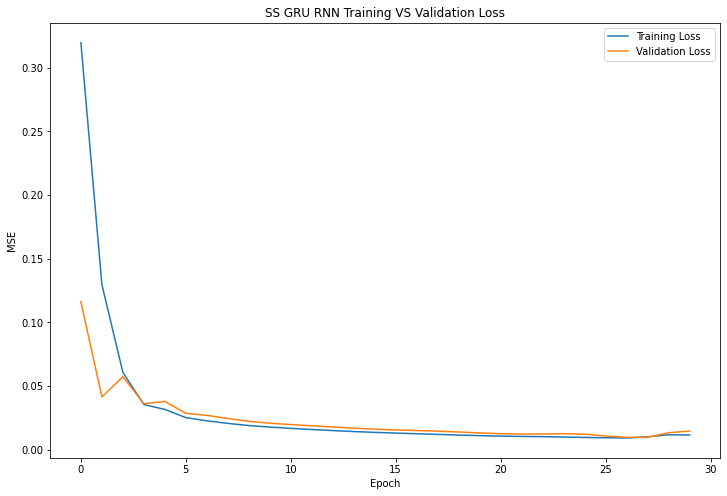

In [ ]:
ss_gru_history = compile_and_fit(ss_gru, ww)
ss_model_histories[ss_gru.model_name] = ss_gru_history
plot_training_history(ss_gru_history, ss_gru.model_name)

In [ ]:
ss_gru.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 70, 32)            4864      
                                                                 
 dense_10 (Dense)            (None, 70, 1)             33        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

4/4 [==============================] - 0s 10ms/step - loss: 0.0031


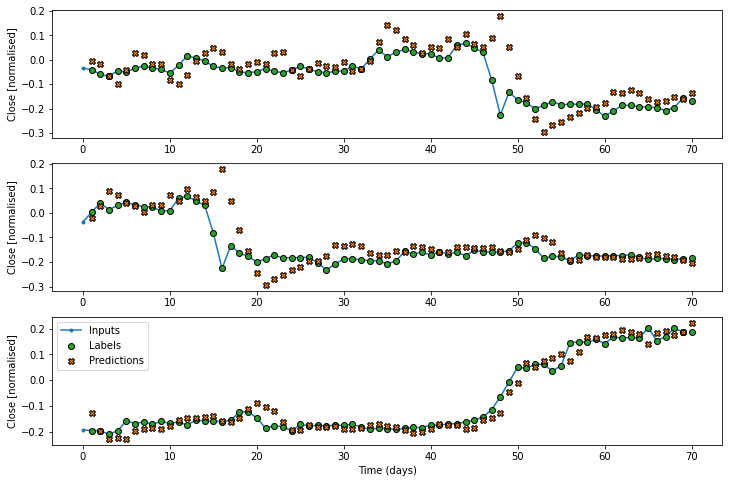

In [ ]:
ss_training_performance[ss_gru.model_name] = ss_gru.evaluate(ww.training_dataset)
ss_validation_performance[ss_gru.model_name] = ss_gru.evaluate(ww.validation_dataset)
ss_testing_performance[ss_gru.model_name] = ss_gru.evaluate(ww.testing_dataset)
ww.plot(model=ss_gru)  # Use SS_LABEL_STEPS=14 and SS_OFFSET=1 for better plot

### Training & Validation Loss Comparison

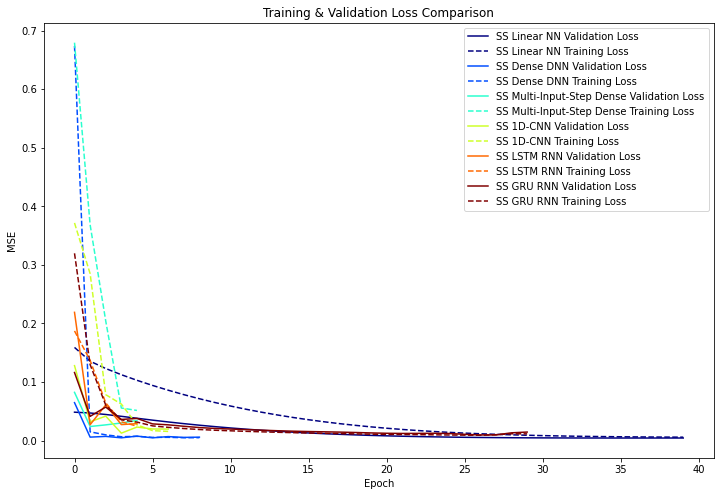

In [ ]:
plot_training_histories(ss_model_histories)

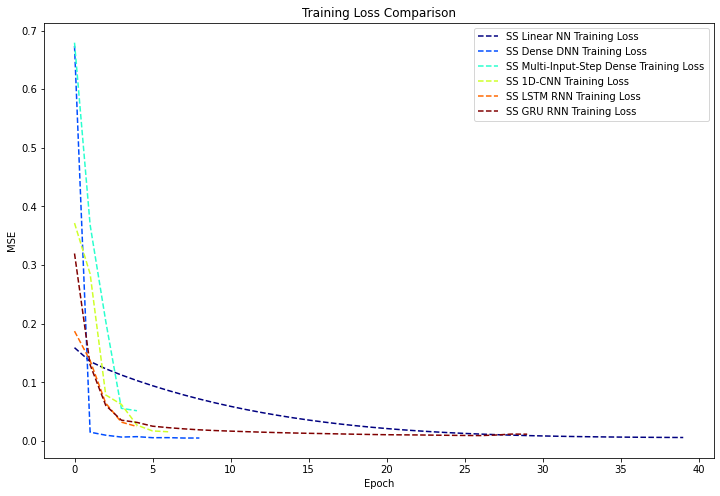

In [ ]:
plot_training_histories(ss_model_histories,
                        validation=False)

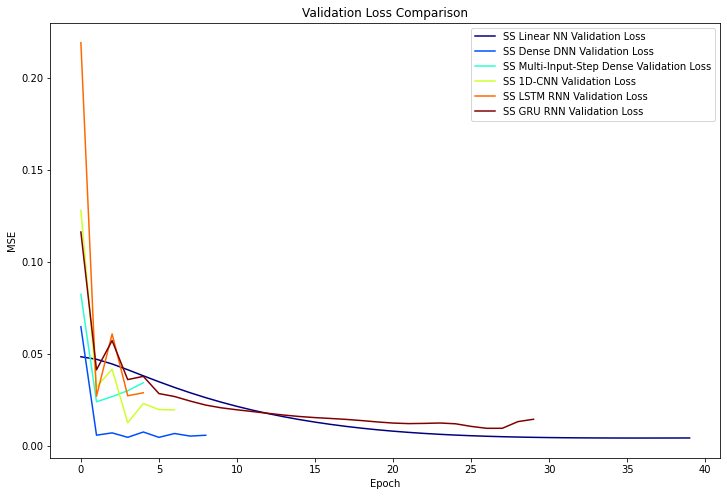

In [ ]:
plot_training_histories(ss_model_histories,
                        training=False)

### Performance

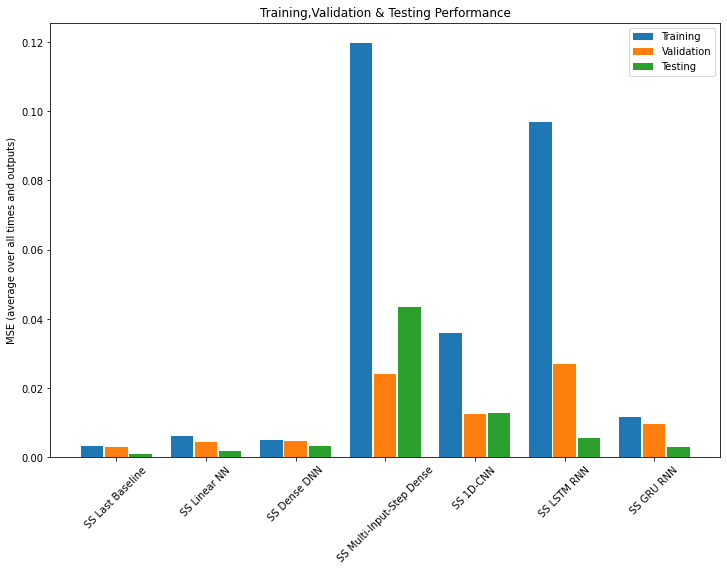

In [ ]:
plot_performance(ss_validation_performance,
                 ss_testing_performance,
                 training_performance=ss_training_performance)

## [Multi-Step](https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models) [Single-Shot](https://www.tensorflow.org/tutorials/structured_data/time_series#single-shot_models) (Single-Output) Modelling

A single-shot model is one where the model makes the entire sequence prediction in a single step.

Let's create a new window generator with the training, validation and testing data normalised w.r.t to the training data, so that it's ready for training the models we construct.

For a multi-step model, we want it to take `INPUT_STEPS` time steps and to predict the next `LABEL_STEPS` time steps. We want to predict the values of `LABEL_COLUMNS` for each output.

In [ ]:
LABEL_STEPS = 7
N_LABEL_FEATURES = len(LABEL_COLUMNS)

w = WindowGenerator(training_df,
                    validation_df,
                    testing_df,
                    input_steps=INPUT_STEPS,
                    label_steps=LABEL_STEPS,
                    offset=LABEL_STEPS,
                    scale_columns=SCALE_COLUMNS,
                    label_columns=LABEL_COLUMNS)
inputs, labels = w.example
print('Input shape:', inputs.shape)
print('Labels shape:', labels.shape)
w

Input shape: (32, 14, 5)
Labels shape: (32, 7, 1)


Total window size: 21
Input step indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label step indices: [14 15 16 17 18 19 20]
Label column names: ['Close']

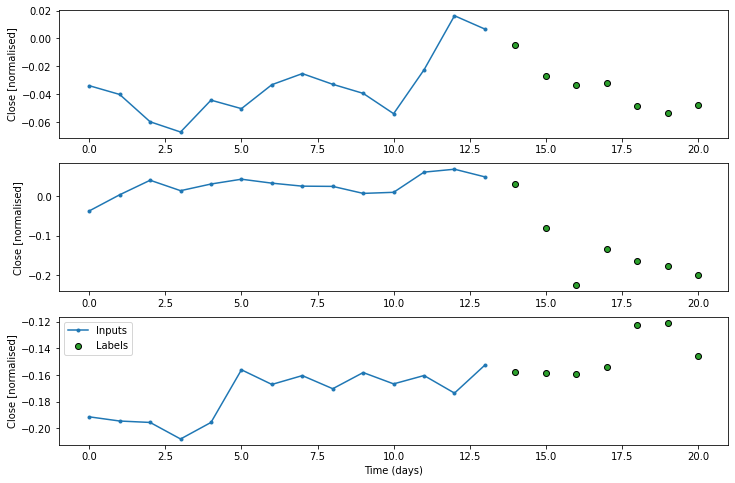

In [ ]:
w.plot()

We will compare the validation and testing datasets' performance on each model.

In [ ]:
model_histories = dict()
training_performance = dict()
validation_performance = dict()
testing_performance = dict()

An important thing to do is to ensure we initialise the `kernel_initializer` keyword argument of some layers.

Because we are doing multi-step predictions, we need to make sure that the layer kernels (weights, not biases) are initialised with values that allows the model to have a higher likelihood of learning complex patterns from data when training.

* In the TensorFlow tutorial, they initialise `kernel_initializer=tf.initializers.zeros()` and for their use case it worked. However, when we use this, all the predictions on the evaluation plots follow a straight line.
* This might be because during backpropagation, the gradient of the loss function is computed w.r.t. the weights and biases in the network. If they are all initialised to the same value, then all the weights in the layer are more likely to receive the same gradient updates.
* If all the weights in the layer receive the same gradient updates, then there will be a high degree of symmetry in the network. This will hinder the model's ability to learn any complex patterns that could be present in the underlying training data's distribution.

We can use `tf.keras.initializers.HeUniform()`:

* Initialises weights by sampling the He uniform distribution (a.k.a. Kaiming initialisation).
* This scales initial weights based on the number of input units in the weight tensor.
* Better for activation functions with linear shape, like `'relu'`.

We could also use the default `kernel_initializer=tf.keras.initializers.GlorotUniform`:

* Initialises weights by sampling the Glorot uniform distribution (a.k.a. Xavier uniform initialisation).
* This scales weights based on the number of input units and output units in the weight tensor.
* Better for activation functions with `'sigmoidal'` shape, like `'tanh'`.

We could also tune `kernel_initializer` during hyper-parameter tuning as selecting a good kernel initialisation method can help the model converge faster and achieve better performance.

### Baseline (Last Time Step)

#### Model Construction

In [ ]:
class LastBaseline(tf.keras.Model):

    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :],
                       [1, LABEL_STEPS, 1])


last_baseline = LastBaseline()
last_baseline.model_name = 'Last Baseline'

#### Training (Not Really)

In [ ]:
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError())
last_baseline.build(input_shape=(None, INPUT_STEPS, N_FEATURES))
last_baseline.summary()

Model: "last_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

6/6 [==============================] - 0s 5ms/step - loss: 0.1092


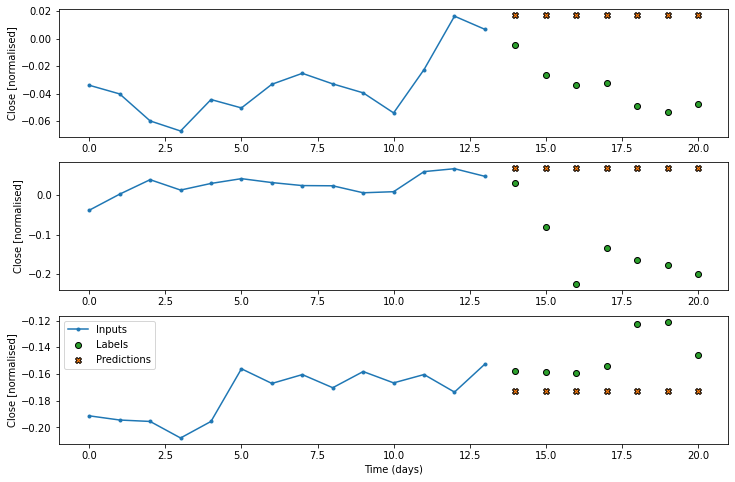

In [ ]:
training_performance[last_baseline.model_name] = last_baseline.evaluate(w.training_dataset)
validation_performance[last_baseline.model_name] = last_baseline.evaluate(w.validation_dataset)
testing_performance[last_baseline.model_name] = last_baseline.evaluate(w.testing_dataset)
w.plot(last_baseline)

### Baseline (Repeat Last `LABEL_STEPS` Time Steps Of The Input Time Steps)

#### Model Construction

In [ ]:
class RepeatBaseline(tf.keras.Model):

    def call(self, inputs):
        return inputs[:, -LABEL_STEPS:, :]


repeat_baseline = RepeatBaseline()
repeat_baseline.model_name = 'Repeat Baseline'

#### Training (Not Really)

In [ ]:
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError())
repeat_baseline.build(input_shape=(None, LABEL_STEPS, N_FEATURES))
repeat_baseline.summary()

Model: "repeat_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

6/6 [==============================] - 0s 6ms/step - loss: 0.1150


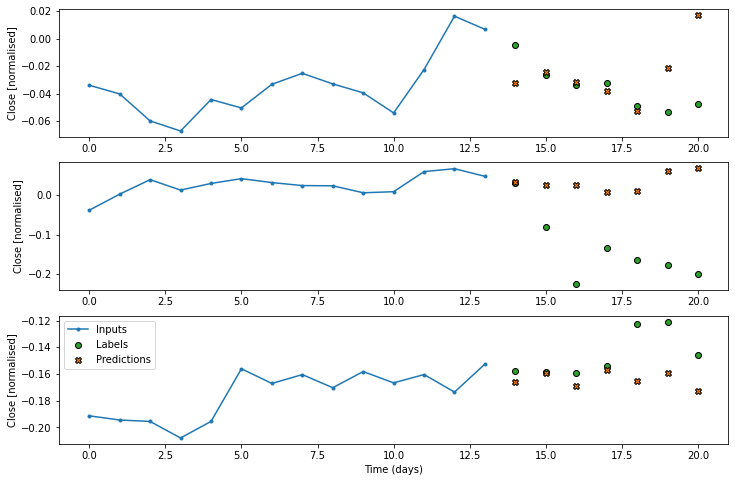

In [ ]:
training_performance[repeat_baseline.model_name] = repeat_baseline.evaluate(w.training_dataset)
validation_performance[repeat_baseline.model_name] = repeat_baseline.evaluate(w.validation_dataset)
testing_performance[repeat_baseline.model_name] = repeat_baseline.evaluate(w.testing_dataset)
w.plot(repeat_baseline)

### [Linear Model](https://www.tensorflow.org/tutorials/structured_data/time_series#linear)

Based on the last input time step, but underpowered, because it needs to predict `LABEL_STEPS` time steps from a single input time step with a linear projection.

#### Model Construction

In [ ]:
linear = tf.keras.Sequential([
    # (batch_size, input_steps, input_features)
    # Gets last time step
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # => (batch_size, 1, input_features)
    tf.keras.layers.Dense(LABEL_STEPS * N_LABEL_FEATURES),
    # => (batch_size, 1, label_steps * label_features)
    tf.keras.layers.Reshape([LABEL_STEPS, N_LABEL_FEATURES])
    # => (batch_size, label_steps, label_features)
])
linear.model_name = 'Linear NN'

#### Training

Epoch 1/100
46/46 [==============================] - 1s 12ms/step - loss: 1.7878 - val_loss: 0.4346
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: 1.4433 - val_loss: 0.3560
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: 1.1912 - val_loss: 0.2925
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: 0.9823 - val_loss: 0.2400
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: 0.8076 - val_loss: 0.1964
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 0.6614 - val_loss: 0.1604
Epoch 7/100
46/46 [==============================] - 0s 5ms/step - loss: 0.5395 - val_loss: 0.1307
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: 0.4385 - val_loss: 0.1065
Epoch 9/100
46/46 [==============================] - 0s 6ms/step - loss: 0.3552 - val_loss: 0.0869
Epoch 10/100
46/46 [==============================] - 0s 6ms/step - loss: 0.2870 - val_loss: 0.0710
Epoch 11

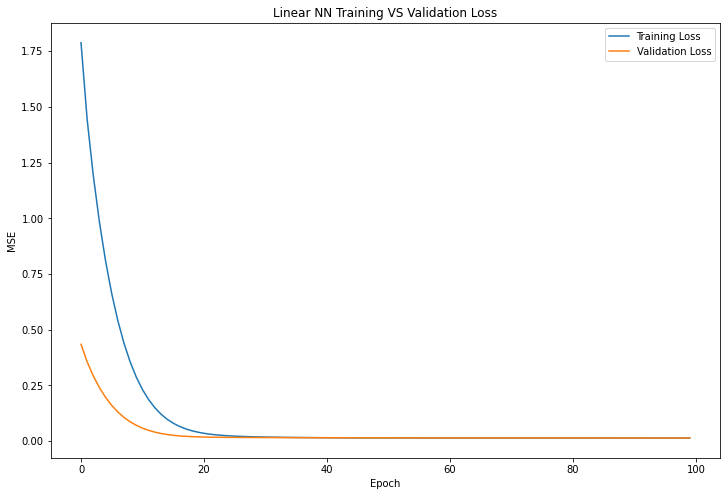

In [ ]:
linear_history = compile_and_fit(linear, w)
model_histories[linear.model_name] = linear_history
plot_training_history(linear_history, linear.model_name)

In [ ]:
linear.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 5)              0         
                                                                 
 dense_11 (Dense)            (None, 1, 7)              42        
                                                                 
 reshape_1 (Reshape)         (None, 7, 1)              0         
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

6/6 [==============================] - 0s 8ms/step - loss: 0.0057


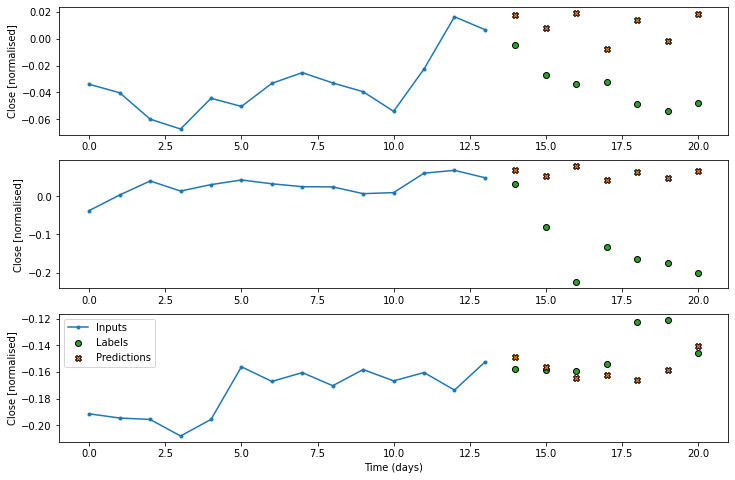

In [ ]:
training_performance[linear.model_name] = linear.evaluate(w.training_dataset)
validation_performance[linear.model_name] = linear.evaluate(w.validation_dataset)
testing_performance[linear.model_name] = linear.evaluate(w.testing_dataset)
w.plot(model=linear)

### Dense Model

#### Model Construction

In [ ]:
dense = tf.keras.Sequential([
    # (batch_size, input_steps, input_features)
    # Gets last time step
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # => (batch_size, 1, input_features)
    tf.keras.layers.Dense(512,
                          activation='relu'),
    # => (batch_size, 1, dense_units)
    tf.keras.layers.Dense(LABEL_STEPS * N_LABEL_FEATURES),
    # => (batch_size, 1, label_steps * label_features)
    tf.keras.layers.Reshape([LABEL_STEPS, N_LABEL_FEATURES])
    # => (batch_size, label_steps, label_features)
])
dense.model_name = 'Dense DNN'

#### Training

Epoch 1/100
46/46 [==============================] - 1s 10ms/step - loss: 0.9083 - val_loss: 0.2287
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: 0.6781 - val_loss: 0.1718
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 0.4945 - val_loss: 0.1255
Epoch 4/100
46/46 [==============================] - 0s 7ms/step - loss: 0.3440 - val_loss: 0.0878
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: 0.2270 - val_loss: 0.0585
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 0.1427 - val_loss: 0.0379
Epoch 7/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0867 - val_loss: 0.0255
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0527 - val_loss: 0.0197
Epoch 9/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0336 - val_loss: 0.0182
Epoch 10/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0239 - val_loss: 0.0188
Epoch 11

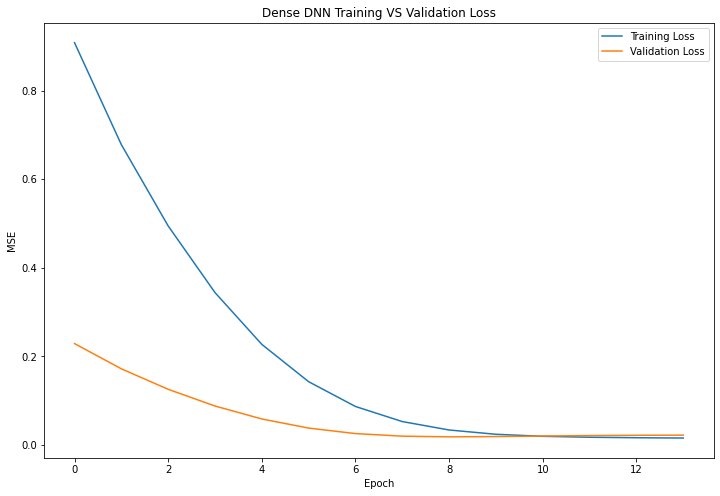

In [ ]:
dense_history = compile_and_fit(dense, w, patience=5, learning_rate=1e-4)
model_histories[dense.model_name] = dense_history
plot_training_history(dense_history, dense.model_name)

In [ ]:
dense.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 5)              0         
                                                                 
 dense_12 (Dense)            (None, 1, 512)            3072      
                                                                 
 dense_13 (Dense)            (None, 1, 7)              3591      
                                                                 
 reshape_2 (Reshape)         (None, 7, 1)              0         
                                                                 
Total params: 6,663
Trainable params: 6,663
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

6/6 [==============================] - 0s 4ms/step - loss: 0.0138


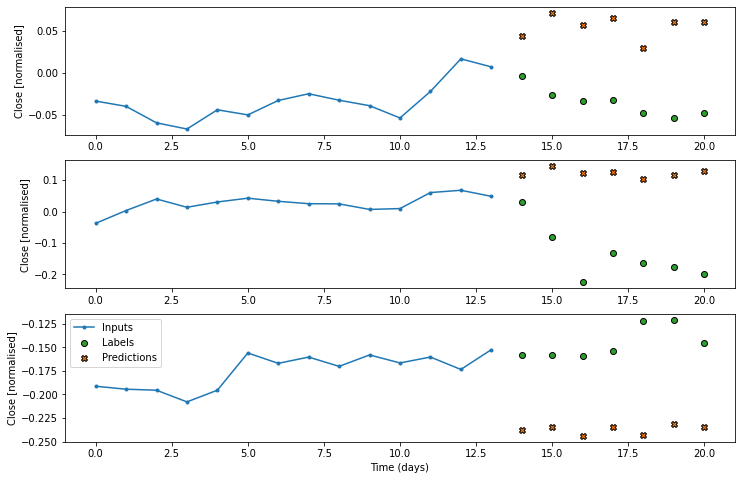

In [ ]:
training_performance[dense.model_name] = dense.evaluate(w.training_dataset)
validation_performance[dense.model_name] = dense.evaluate(w.validation_dataset)
testing_performance[dense.model_name] = dense.evaluate(w.testing_dataset)
w.plot(model=dense)

### [Temporal 1D-CNN](https://www.tensorflow.org/tutorials/structured_data/time_series#cnn)

A CNN makes predictions based on a fixed-width window of past time steps, so it can learn how features change over time, and potentially perform better than models that only use the previous time step.

#### Model Construction

In [ ]:
cnn = tf.keras.Sequential([
    # (batch_size, input_steps, input_features)
    # Gets last CONV_STEPS time steps
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_STEPS:, :]),
    # => (batch_size, CONV_STEPS, input_features)
    tf.keras.layers.Conv1D(filters=256,
                           kernel_size=(CONV_STEPS),
                           activation='relu'),
    # => (batch_size, 1, 256)
    tf.keras.layers.Dense(LABEL_STEPS * N_LABEL_FEATURES),
    # => (batch_size, 1,  label_steps * label_features)
    tf.keras.layers.Reshape([LABEL_STEPS, N_LABEL_FEATURES])
    # => (batch_size, label_steps, label_features)
])
cnn.model_name = '1D-CNN'

#### Training

Epoch 1/100
46/46 [==============================] - 2s 15ms/step - loss: 0.5637 - val_loss: 0.0584
Epoch 2/100
46/46 [==============================] - 0s 10ms/step - loss: 0.0698 - val_loss: 0.0251
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0353 - val_loss: 0.0318
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0333 - val_loss: 0.0311
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0322 - val_loss: 0.0311
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0313 - val_loss: 0.0309
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0306 - val_loss: 0.0308


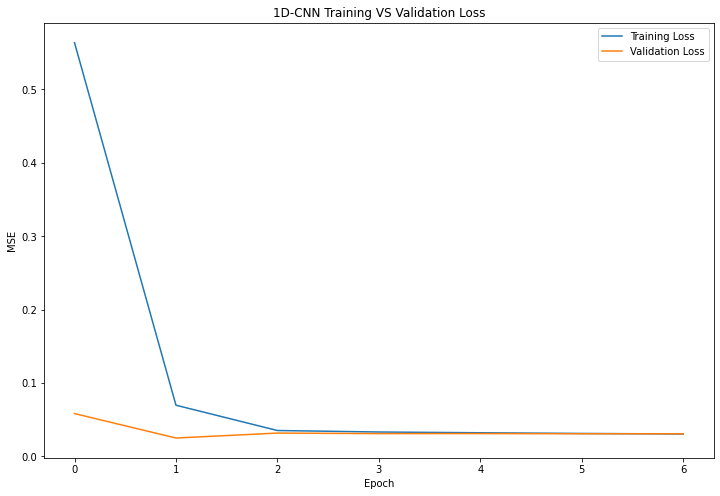

In [ ]:
cnn_history = compile_and_fit(cnn, w, patience=5, learning_rate=1e-4)
model_histories[cnn.model_name] = cnn_history
plot_training_history(cnn_history, cnn.model_name)

In [ ]:
cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 14, 5)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 256)            18176     
                                                                 
 dense_14 (Dense)            (None, 1, 7)              1799      
                                                                 
 reshape_3 (Reshape)         (None, 7, 1)              0         
                                                                 
Total params: 19,975
Trainable params: 19,975
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

6/6 [==============================] - 0s 7ms/step - loss: 0.0198


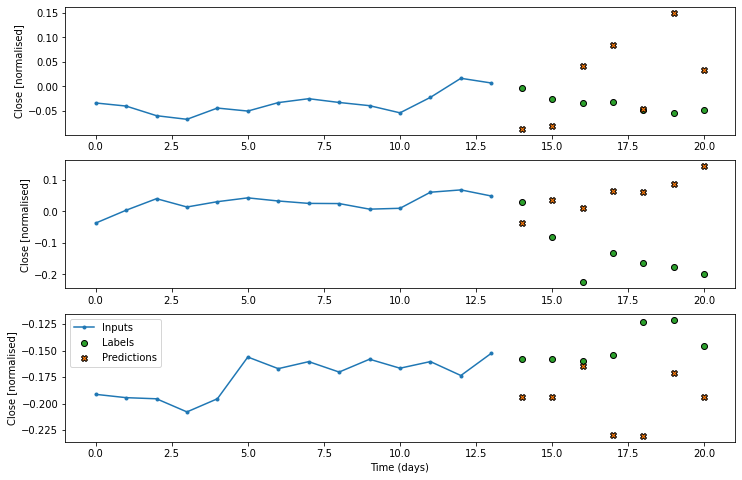

In [ ]:
training_performance[cnn.model_name] = cnn.evaluate(w.training_dataset)
validation_performance[cnn.model_name] = cnn.evaluate(w.validation_dataset)
testing_performance[cnn.model_name] = cnn.evaluate(w.testing_dataset)
w.plot(model=cnn)

### [Stateless LSTM RNN](https://www.tensorflow.org/tutorials/structured_data/time_series#rnn_2)

See time series forecasting tutorial section ["Recurrent neural network"](https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network) on when to set `return_sequences` to `True` or `False` and for the diagrams.

1. [`LSTM(32, return_sequences=False)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): `return_sequences` is set to `False`, so the model can "warm up" its internal state before making a single prediction for the timestep after the input window.
2. [`Dense(1)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): 1 neuron since we only want one value (the next price).

#### Model Construction

In [ ]:
lstm = tf.keras.Sequential([
    # (batch_size, input_steps, features)
    # Note: Adding more `lstm_units` causes overfitting more quickly.
    tf.keras.layers.LSTM(32,
                         dropout=0.1,  # Training regularisation
                         return_sequences=False),
    # => (batch_size, lstm_units)
    tf.keras.layers.Dense(LABEL_STEPS * N_LABEL_FEATURES,
                          kernel_initializer='he_uniform'),
    # => (batch_size, label_steps * label_features)
    tf.keras.layers.Reshape([LABEL_STEPS, N_LABEL_FEATURES])
    # => (batch_size, label_steps, label_features)
])
lstm.model_name = 'Stateless LSTM RNN'

#### Training

Epoch 1/100
46/46 [==============================] - 4s 24ms/step - loss: 0.8731 - val_loss: 0.1706
Epoch 2/100
46/46 [==============================] - 1s 13ms/step - loss: 0.4054 - val_loss: 0.0648
Epoch 3/100
46/46 [==============================] - 1s 12ms/step - loss: 0.1651 - val_loss: 0.1021
Epoch 4/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0862 - val_loss: 0.1647
Epoch 5/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0677 - val_loss: 0.1654
Epoch 6/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0610 - val_loss: 0.1424
Epoch 7/100
46/46 [==============================] - 1s 19ms/step - loss: 0.0542 - val_loss: 0.1132


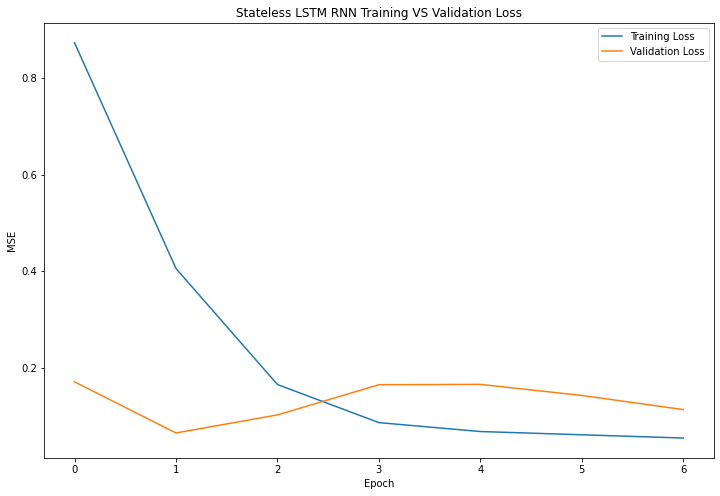

In [ ]:
lstm_history = compile_and_fit(lstm, w, patience=5, learning_rate=5e-4)
model_histories[lstm.model_name] = lstm_history
plot_training_history(lstm_history, lstm.model_name)

In [ ]:
lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4864      
                                                                 
 dense_15 (Dense)            (None, 7)                 231       
                                                                 
 reshape_4 (Reshape)         (None, 7, 1)              0         
                                                                 
Total params: 5,095
Trainable params: 5,095
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

6/6 [==============================] - 0s 6ms/step - loss: 0.0594


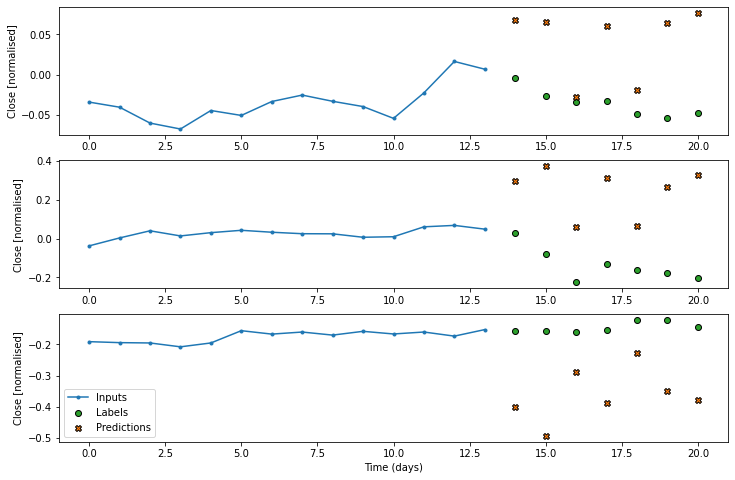

In [ ]:
training_performance[lstm.model_name] = lstm.evaluate(w.training_dataset)
validation_performance[lstm.model_name] = lstm.evaluate(w.validation_dataset)
testing_performance[lstm.model_name] = lstm.evaluate(w.testing_dataset)
w.plot(model=lstm)

### Stacked Stateless LSTM RNN



#### Model Construction

In [ ]:
stacked_lstm = tf.keras.Sequential([
    # Based on: https://ieeexplore.ieee.org/document/9848887
    # (batch_size, input_steps, input_features)
    tf.keras.layers.LSTM(50,
                         dropout=0.1,
                         return_sequences=True),
    # => (batch_size, input_steps, lstm_units)
    tf.keras.layers.LSTM(50,
                         dropout=0.1,
                         return_sequences=True),
    # => (batch_size, input_steps, lstm_units)
    tf.keras.layers.LSTM(50,
                         dropout=0.1,
                         return_sequences=True),
    # => (batch_size, input_steps, lstm_units)
    tf.keras.layers.LSTM(50,
                         dropout=0.1,
                         return_sequences=False),
    # => (batch_size, lstm_units)
    tf.keras.layers.Dense(LABEL_STEPS * N_LABEL_FEATURES),
    # => (batch_size, label_steps * label_features)
    tf.keras.layers.Reshape([LABEL_STEPS, N_LABEL_FEATURES])
    # => (batch_size, label_steps, label_features)
])
stacked_lstm.model_name = 'Stacked Stateless LSTM RNN'

#### Training

Epoch 1/100
46/46 [==============================] - 13s 83ms/step - loss: 0.4548 - val_loss: 0.2508
Epoch 2/100
46/46 [==============================] - 2s 41ms/step - loss: 0.1342 - val_loss: 0.2632
Epoch 3/100
46/46 [==============================] - 2s 41ms/step - loss: 0.1057 - val_loss: 0.3895
Epoch 4/100
46/46 [==============================] - 2s 40ms/step - loss: 0.0798 - val_loss: 0.2122
Epoch 5/100
46/46 [==============================] - 2s 43ms/step - loss: 0.0807 - val_loss: 0.2911
Epoch 6/100
46/46 [==============================] - 3s 55ms/step - loss: 0.0663 - val_loss: 0.1671
Epoch 7/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0649 - val_loss: 0.1716
Epoch 8/100
46/46 [==============================] - 2s 41ms/step - loss: 0.0640 - val_loss: 0.1659
Epoch 9/100
46/46 [==============================] - 2s 41ms/step - loss: 0.0568 - val_loss: 0.1515
Epoch 10/100
46/46 [==============================] - 2s 40ms/step - loss: 0.0539 - val_loss: 0.149

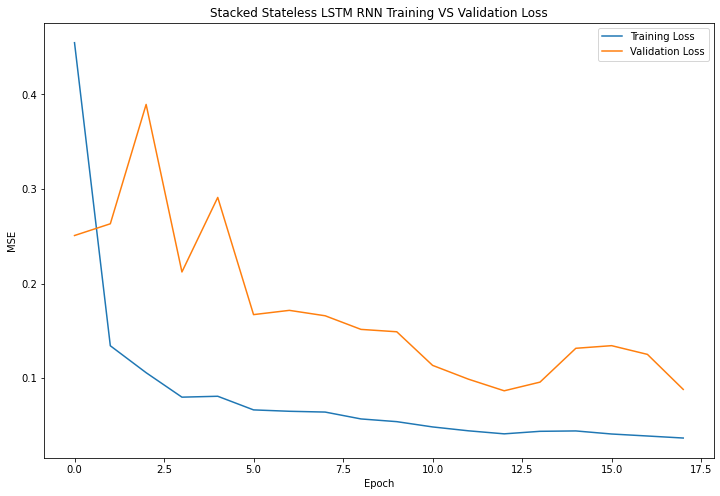

In [ ]:
stacked_lstm_history = compile_and_fit(stacked_lstm, w, patience=5, learning_rate=5e-4)
model_histories[stacked_lstm.model_name] = stacked_lstm_history
plot_training_history(stacked_lstm_history, stacked_lstm.model_name)

In [ ]:
stacked_lstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 14, 50)            11200     
                                                                 
 lstm_4 (LSTM)               (None, 14, 50)            20200     
                                                                 
 lstm_5 (LSTM)               (None, 14, 50)            20200     
                                                                 
 lstm_6 (LSTM)               (None, 50)                20200     
                                                                 
 dense_16 (Dense)            (None, 7)                 357       
                                                                 
 reshape_5 (Reshape)         (None, 7, 1)              0         
                                                                 
Total params: 72,157
Trainable params: 72,157
Non-tra

#### Evaluation

6/6 [==============================] - 0s 12ms/step - loss: 0.0229


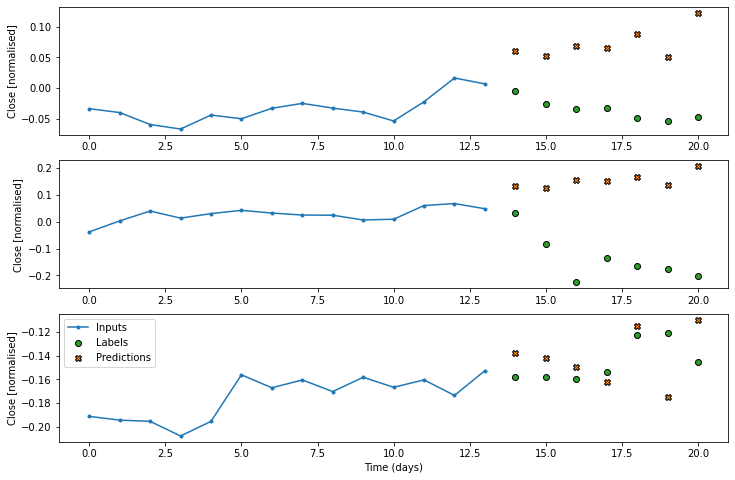

In [ ]:
training_performance[stacked_lstm.model_name] = stacked_lstm.evaluate(w.training_dataset)
validation_performance[stacked_lstm.model_name] = stacked_lstm.evaluate(w.validation_dataset)
testing_performance[stacked_lstm.model_name] = stacked_lstm.evaluate(w.testing_dataset)
w.plot(model=stacked_lstm)

### [Stateless GRU RNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)

#### Model Construction

In [ ]:
gru = tf.keras.Sequential([
    # (batch_size, input_steps, features)
    # QUESTION: Does adding more `gru_units` causes overfitting more quickly like LSTM too?
    tf.keras.layers.GRU(32,
                        dropout=0.1,  # Training regularisation
                        return_sequences=False),
    # => (batch_size, gru_units)
    tf.keras.layers.Dense(LABEL_STEPS * N_LABEL_FEATURES,
                          kernel_initializer='he_uniform'),
    # => (batch_size, label_steps * label_features)
    tf.keras.layers.Reshape([LABEL_STEPS, N_LABEL_FEATURES])
    # => (batch_size, label_steps, label_features)
])
gru.model_name = 'Stateless GRU RNN'

#### Training

Epoch 1/100
46/46 [==============================] - 4s 25ms/step - loss: 0.6184 - val_loss: 0.0945
Epoch 2/100
46/46 [==============================] - 1s 14ms/step - loss: 0.1858 - val_loss: 0.0223
Epoch 3/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0625 - val_loss: 0.0443
Epoch 4/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0458 - val_loss: 0.0628
Epoch 5/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0381 - val_loss: 0.0646
Epoch 6/100
46/46 [==============================] - 1s 13ms/step - loss: 0.0357 - val_loss: 0.0619
Epoch 7/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0325 - val_loss: 0.0590


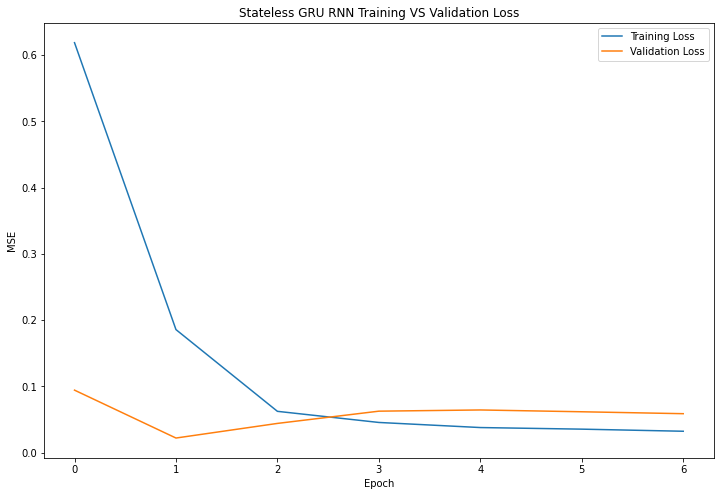

In [ ]:
gru_history = compile_and_fit(gru, w, patience=5, learning_rate=5e-4)
model_histories[gru.model_name] = gru_history
plot_training_history(gru_history, gru.model_name)

In [ ]:
gru.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3744      
                                                                 
 dense_17 (Dense)            (None, 7)                 231       
                                                                 
 reshape_6 (Reshape)         (None, 7, 1)              0         
                                                                 
Total params: 3,975
Trainable params: 3,975
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

6/6 [==============================] - 0s 6ms/step - loss: 0.0182


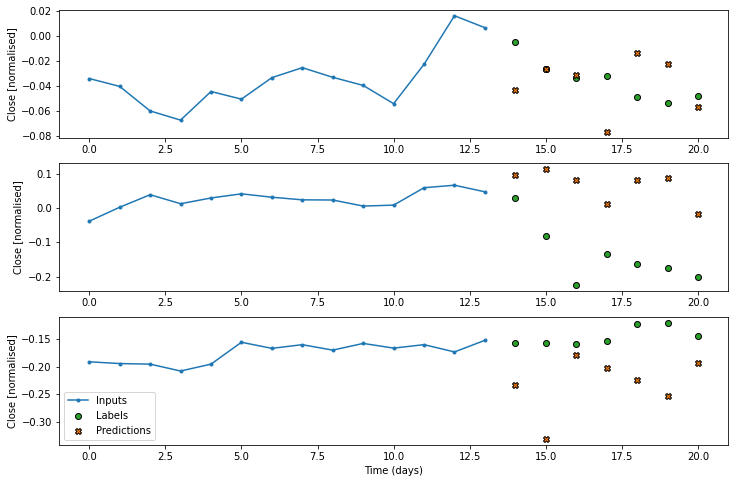

In [ ]:
training_performance[gru.model_name] = gru.evaluate(w.training_dataset)
validation_performance[gru.model_name] = gru.evaluate(w.validation_dataset)
testing_performance[gru.model_name] = gru.evaluate(w.testing_dataset)
w.plot(model=gru)

### Stacked Stateless GRU RNN

#### Model Construction

In [ ]:
stacked_gru = tf.keras.Sequential([
    # Based on: https://ieeexplore.ieee.org/document/9848887
    # (batch_size, input_steps, input_features)
    tf.keras.layers.GRU(50,
                        dropout=0.1,
                        return_sequences=True),
    # => (batch_size, input_steps, lstm_units)
    tf.keras.layers.GRU(50,
                        dropout=0.1,
                        return_sequences=True),
    # => (batch_size, input_steps, lstm_units)
    tf.keras.layers.GRU(50,
                        dropout=0.1,
                        return_sequences=True),
    # => (batch_size, input_steps, lstm_units)
    tf.keras.layers.GRU(50,
                        dropout=0.1,
                        return_sequences=False),
    # => (batch_size, lstm_units)
    tf.keras.layers.Dense(LABEL_STEPS * N_LABEL_FEATURES),
    # => (batch_size, label_steps * label_features)
    tf.keras.layers.Reshape([LABEL_STEPS, N_LABEL_FEATURES])
    # => (batch_size, label_steps, label_features)
])
stacked_gru.model_name = 'Stacked Stateless GRU RNN'

#### Training

Epoch 1/100
46/46 [==============================] - 13s 81ms/step - loss: 0.2261 - val_loss: 0.3110
Epoch 2/100
46/46 [==============================] - 3s 55ms/step - loss: 0.1381 - val_loss: 0.2316
Epoch 3/100
46/46 [==============================] - 2s 40ms/step - loss: 0.0639 - val_loss: 0.1691
Epoch 4/100
46/46 [==============================] - 2s 41ms/step - loss: 0.0561 - val_loss: 0.1362
Epoch 5/100
46/46 [==============================] - 2s 41ms/step - loss: 0.0491 - val_loss: 0.1080
Epoch 6/100
46/46 [==============================] - 2s 40ms/step - loss: 0.0449 - val_loss: 0.0997
Epoch 7/100
46/46 [==============================] - 3s 67ms/step - loss: 0.0420 - val_loss: 0.0824
Epoch 8/100
46/46 [==============================] - 2s 43ms/step - loss: 0.0377 - val_loss: 0.0628
Epoch 9/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0368 - val_loss: 0.0646
Epoch 10/100
46/46 [==============================] - 2s 41ms/step - loss: 0.0363 - val_loss: 0.055

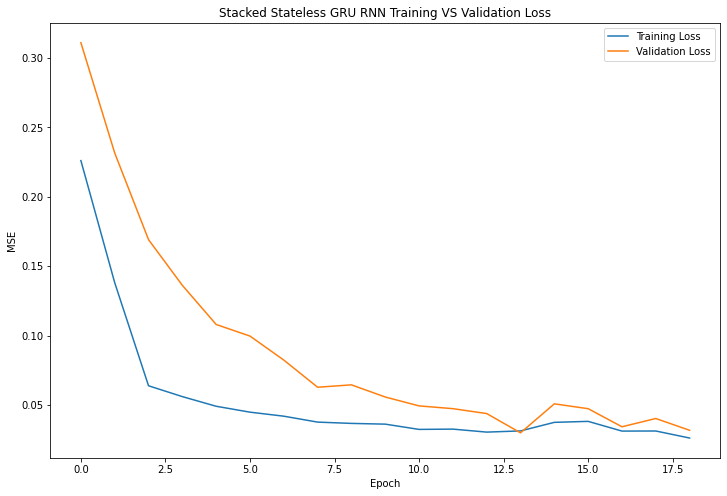

In [ ]:
stacked_gru_history = compile_and_fit(stacked_gru, w, patience=5, learning_rate=5e-4)
model_histories[stacked_gru.model_name] = stacked_gru_history
plot_training_history(stacked_gru_history, stacked_gru.model_name)

In [ ]:
stacked_gru.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 14, 50)            8550      
                                                                 
 gru_2 (GRU)                 (None, 14, 50)            15300     
                                                                 
 gru_3 (GRU)                 (None, 14, 50)            15300     
                                                                 
 gru_4 (GRU)                 (None, 50)                15300     
                                                                 
 dense_18 (Dense)            (None, 7)                 357       
                                                                 
 reshape_7 (Reshape)         (None, 7, 1)              0         
                                                                 
Total params: 54,807
Trainable params: 54,807
Non-tra

#### Evaluation

6/6 [==============================] - 0s 12ms/step - loss: 0.0087


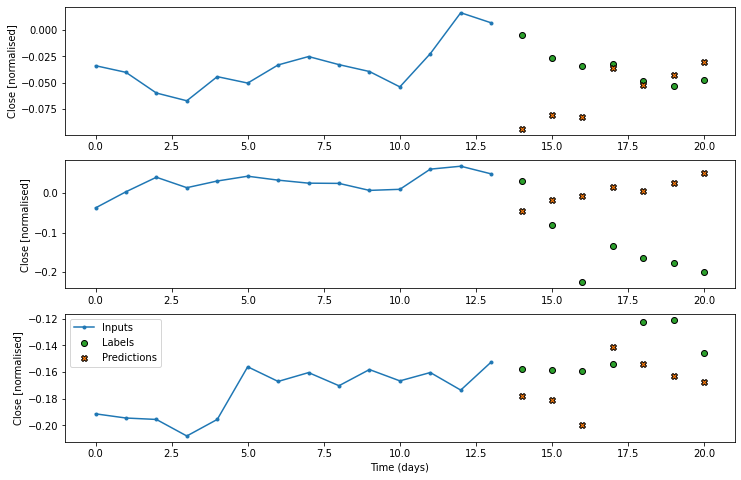

In [ ]:
training_performance[stacked_gru.model_name] = stacked_gru.evaluate(w.training_dataset)
validation_performance[stacked_gru.model_name] = stacked_gru.evaluate(w.validation_dataset)
testing_performance[stacked_gru.model_name] = stacked_gru.evaluate(w.testing_dataset)
w.plot(model=stacked_gru)

### Training & Validation Loss Comparison

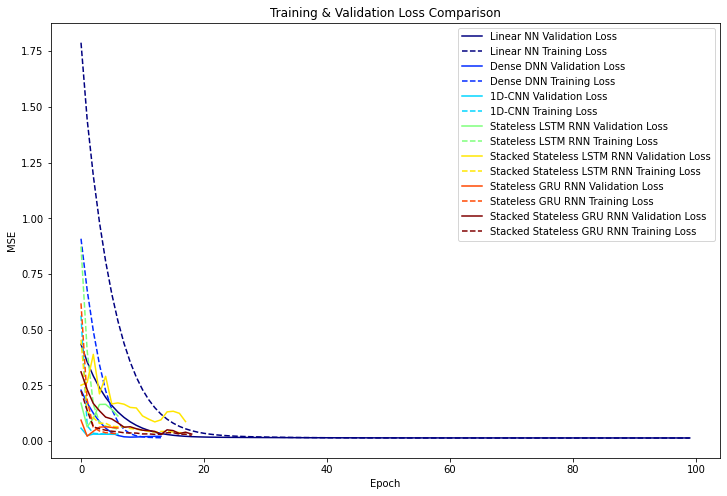

In [ ]:
plot_training_histories(model_histories)

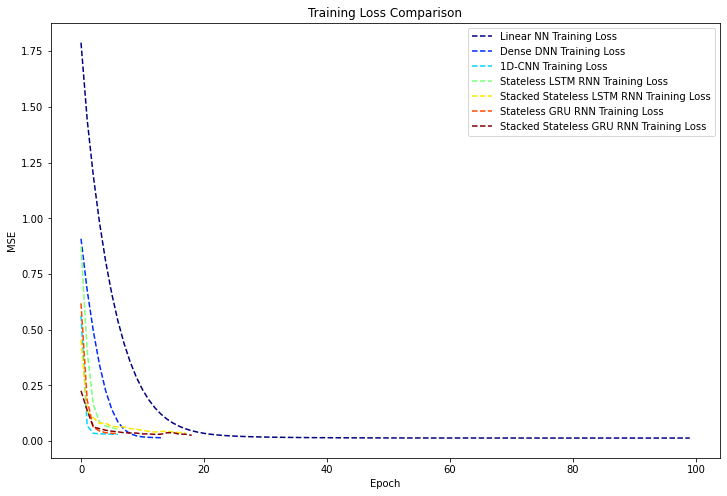

In [ ]:
plot_training_histories(model_histories,
                        validation=False)

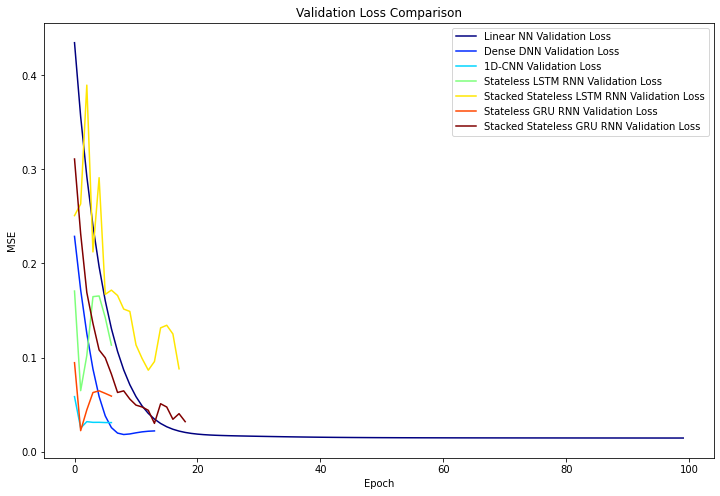

In [ ]:
plot_training_histories(model_histories,
                        training=False)

### Training Time Comparison

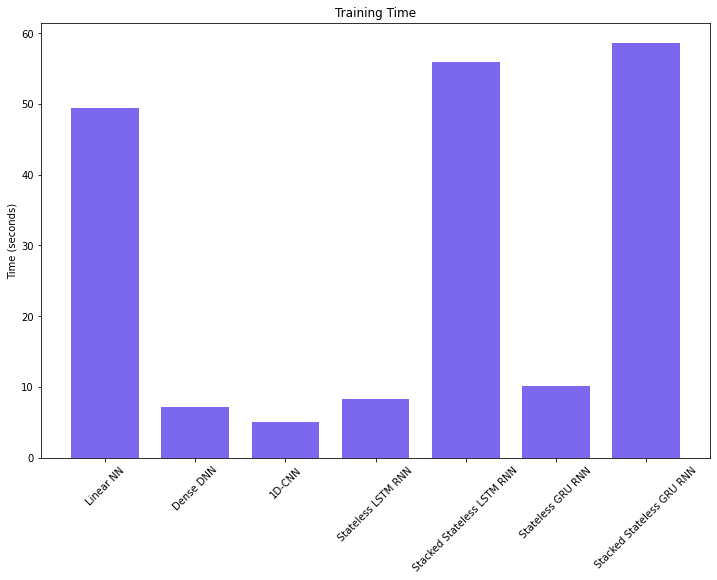

In [ ]:
plot_training_time(model_histories)

### Performance

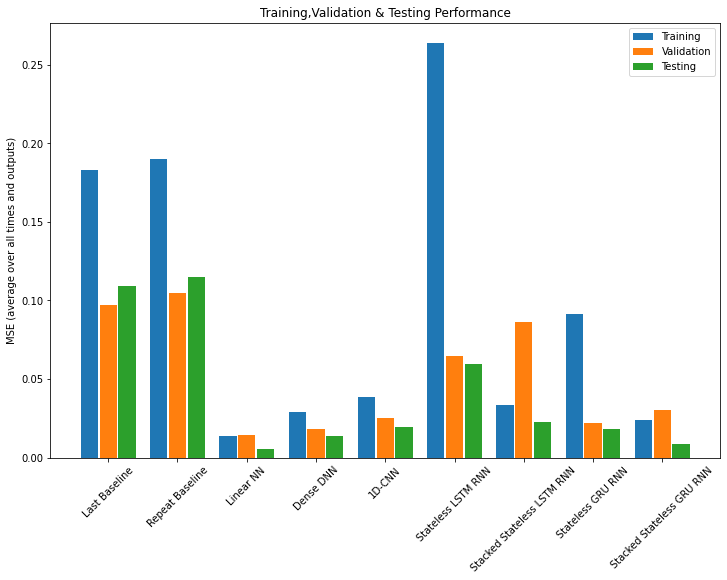

In [ ]:
plot_performance(validation_performance,
                 testing_performance,
                 training_performance=training_performance)

We could conclude from this that, based on testing loss, Linear NN, Stacked Stateless GRU RNN and 1D-CNN with a convolutional window of size 14 did the best (in that order), so that means we could choose one of these for our 7-day cryptocurrency predition depending on other factors like time it took to train or the number of epochs.

## Advanced: [Multi-Step](https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models) [Autoregressive](https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model) Modelling

A multi-step autoregressive model works by making many single-step predictions by feeding the previous time step output as the next time step input in sequence.

In general, to implement an auto-regressive model for `n`-step prediction:

1. Create a new model class, that subclasses `tf.keras.Model`.
2. If the model contains an internal state, implement a warm-up method to warm it up (using the single-step model architecture).
3. Implement the `tf.keras.Model.call()` method.
    1. If there was a warm-up method, call it on `inputs` so that we can generate the 1st single-step prediction.
    2. In a loop, for `n - 1` iterations:
        1. Generate the next single-step prediction using the previous single-step prediction as input.
        2. Add this to the collection of single-step predictions.
    3. Return the collection as a multi-step prediction tensor.

Autoregressive modelling requires the input features and output features to be the same because in order to generate single-step predictions that relied on the previous time step, all columns that were used for training need to be available.

We'll create another window for this.

In [ ]:
N_FEATURES = len(training_df.columns)

ar_w = WindowGenerator(training_df,
                       validation_df,
                       testing_df,
                       input_steps=INPUT_STEPS,
                       label_steps=LABEL_STEPS,
                       offset=LABEL_STEPS,
                       scale_columns=SCALE_COLUMNS)

inputs, labels = ar_w.example
print('Inputs shape:', inputs.shape)
print('Labels shape:', labels.shape)
ar_w

Inputs shape: (32, 14, 5)
Labels shape: (32, 7, 5)


Total window size: 21
Input step indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label step indices: [14 15 16 17 18 19 20]
Label column names: None

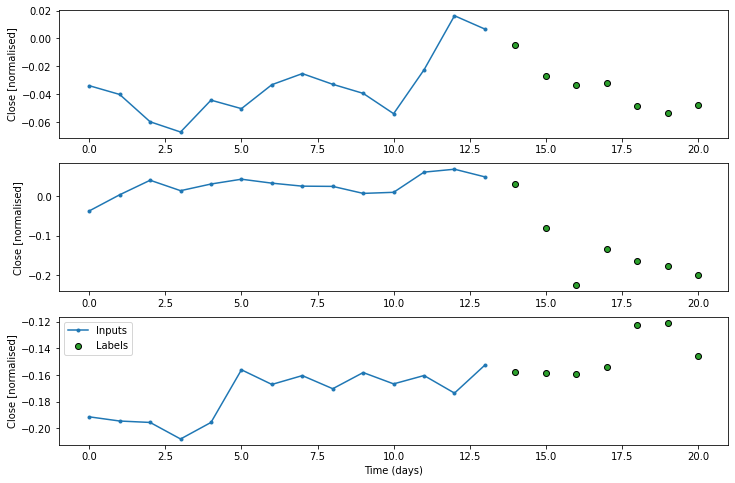

In [ ]:
ar_w.plot()

### [LSTM RNN](https://www.tensorflow.org/tutorials/structured_data/time_series#rnn_3)

#### Model Construction

In [ ]:
class AR_LSTM_RNN(tf.keras.Model):

    def __init__(self,
                 units: int,
                 label_steps: int,
                 n_features: int,
                 *args,
                 **kwargs):
        super(AR_LSTM_RNN, self).__init__(*args, **kwargs)
        
        self.units = units
        self.label_steps = label_steps
        self.n_features = n_features

        # Model architecture
        self.lstm_cell = tf.keras.layers.LSTMCell(self.units)
        self.rnn = tf.keras.layers.RNN(self.lstm_cell,
                                       return_state=True)
        # Above 2 lines are equivalent to:
        #     self.rnn = tf.keras.layers.LSTM(units, return_state=True)
        # But we want to keep a reference to the LSTMCell.
        self.dense = tf.keras.layers.Dense(self.n_features)

    def warmup(self,
               inputs: tf.Tensor,
               training: bool = None) -> Tuple[tf.Tensor, List[tf.Tensor]]:
        """
        Initialises the internal state based on the inputs to capture relevant
        parts of the input history. Equivalent to the single-step model.

        :param inputs: tensor of shape (batch_size, input_steps, features)
        :return: tensor of shape (batch_size, label_steps, features)
                 and the final state of the RNN at the last time step.
        """
        # `state` is the state of the RNN from the previous time step to be used
        # at the next e.g. using LSTMCell returns `state: List[tf.Tensor]` where
        # `len(state) == 2`:
        #     * `state[0]` is the final memory state.
        #     * `state[1]` is the final carry state.
        # (batch_size, input_steps, features)
        output, *state = self.rnn(inputs,
                                  training=training)
        # => (batch_size, units)
        output = self.dense(output,
                            training=training)
        # => (batch_size, features)

        return output, state

    def call(self,
             inputs: tf.Tensor,
             training: bool = None) -> tf.Tensor:
        # Initialise LSTM state.
        # (batch_size, input_steps, features)
        output, state = self.warmup(inputs,
                                    training=training)
        # => (batch_size, features)

        # Object to collect single-step outputs.
        outputs = tf.TensorArray(inputs.dtype,
                                 size=self.label_steps)
        # Insert 1st single-step output.
        outputs = outputs.write(0, output)

        for i in tf.range(1, self.label_steps):
            # Use previous step's output as current step's input and execute one
            # LSTM time step.
            output, state = self.lstm_cell(output,
                                           states=state,
                                           training=training)
            # => (batch_size, units)
            output = self.dense(output,
                                training=training)
            # => (batch_size, features)
            # Insert i-th single-step output.
            outputs = outputs.write(i, output)

        # Convert collection of outputs to tensor
        outputs = outputs.stack()
        # => (label_steps, batch_size, features)
        outputs = tf.transpose(outputs, [1, 0, 2])
        # => (batch_size, label_steps, features)

        return outputs


ar_lstm = AR_LSTM_RNN(32, LABEL_STEPS, N_FEATURES)
ar_lstm.model_name = 'Autoregressive LSTM RNN'

#### Training

Epoch 1/100
46/46 [==============================] - 5s 24ms/step - loss: 0.5818 - val_loss: 0.0931
Epoch 2/100
46/46 [==============================] - 1s 15ms/step - loss: 0.1709 - val_loss: 0.1749
Epoch 3/100
46/46 [==============================] - 1s 15ms/step - loss: 0.1374 - val_loss: 0.1621
Epoch 4/100
46/46 [==============================] - 1s 15ms/step - loss: 0.1050 - val_loss: 0.1647
Epoch 5/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0976 - val_loss: 0.1578
Epoch 6/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0900 - val_loss: 0.0915
Epoch 7/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0908 - val_loss: 0.1085
Epoch 8/100
46/46 [==============================] - 1s 17ms/step - loss: 0.0816 - val_loss: 0.0886
Epoch 9/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0852 - val_loss: 0.1017
Epoch 10/100
46/46 [==============================] - 1s 15ms/step - loss: 0.0880 - val_loss: 0.1066

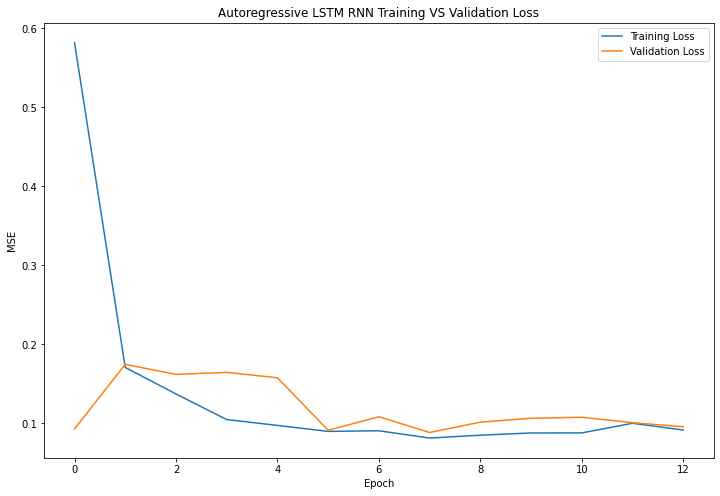

In [ ]:
ar_lstm_history = compile_and_fit(ar_lstm, ar_w, patience=5)
model_histories[ar_lstm.model_name] = ar_lstm_history
plot_training_history(ar_lstm_history, ar_lstm.model_name)

In [ ]:
ar_lstm.summary()

Model: "ar_lstm_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_cell_7 (LSTMCell)      multiple                  4864      
                                                                 
 rnn (RNN)                   multiple                  4864      
                                                                 
 dense_19 (Dense)            multiple                  165       
                                                                 
Total params: 5,029
Trainable params: 5,029
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

6/6 [==============================] - 0s 6ms/step - loss: 0.1016


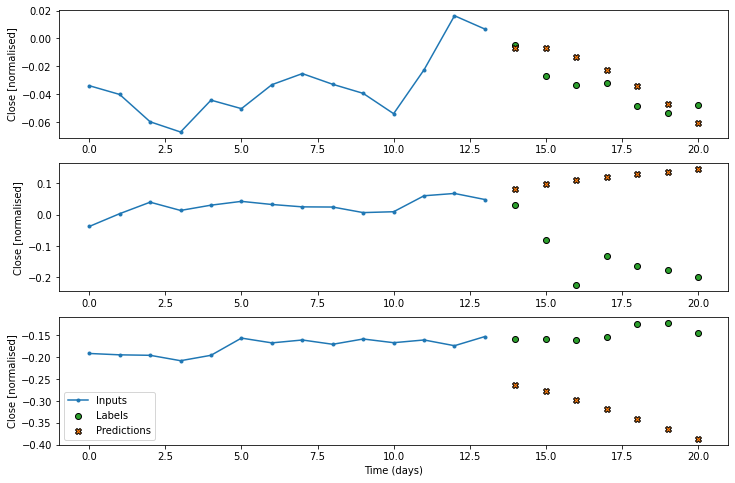

In [ ]:
training_performance[ar_lstm.model_name] = ar_lstm.evaluate(ar_w.training_dataset)
validation_performance[ar_lstm.model_name] = ar_lstm.evaluate(ar_w.validation_dataset)
testing_performance[ar_lstm.model_name] = ar_lstm.evaluate(ar_w.testing_dataset)
ar_w.plot(ar_lstm)

### GRU RNN

Based on previous section for autoregressive LSTM RNN.

#### Model Construction

In [ ]:
class AR_GRU_RNN(tf.keras.Model):

    def __init__(self,
                 units: int,
                 label_steps: int,
                 n_features: int,
                 *args,
                 **kwargs):
        super(AR_GRU_RNN, self).__init__(*args, **kwargs)
        
        self.units = units
        self.label_steps = label_steps
        self.n_features = n_features

        # Model architecture
        self.gru_cell = tf.keras.layers.GRUCell(self.units)
        self.rnn = tf.keras.layers.RNN(self.gru_cell,
                                       return_state=True)
        # Above 2 lines are equivalent to:
        #     self.rnn = tf.keras.layers.GRU(units, return_state=True)
        # But we want to keep a reference to the GRUCell.
        self.dense = tf.keras.layers.Dense(self.n_features)

    def warmup(self,
               inputs: tf.Tensor,
               training: bool = None) -> Tuple[tf.Tensor, List[tf.Tensor]]:
        """
        Initialises the internal state based on the inputs to capture relevant
        parts of the input history. Equivalent to the single-step model.

        :param inputs: tensor of shape (batch_size, input_steps, features)
        :return: single-step output tensor of shape (batch_size, label_steps, features)
                 and the final state of the RNN at the last time step.
        """
        # `state` is the state of the GRUCell layer from the previous time step
        # to be used at the next e.g. using GRUCell returns the final
        # `state: tf.Tensor` which should be carried into the next time step.
        # Shape (batch_size, input_steps, features) => (batch_size, units)
        outputs, state = self.rnn(inputs,
                                  training=training)
        # Shape => (batch_size, features)
        outputs = self.dense(outputs,
                             training=training)

        return outputs, state

    def call(self,
             inputs: tf.Tensor,
             training: bool = None) -> tf.Tensor:
        # Initialise GRU state.
        # (batch_size, input_steps, features)
        output, state = self.warmup(inputs,
                                    training=training)
        # => (batch_size, features)

        # Object to collect single-step outputs.
        outputs = tf.TensorArray(inputs.dtype,
                                 size=self.label_steps)
        # Insert 1st single-step output.
        outputs = outputs.write(0, output)

        for i in tf.range(1, self.label_steps):
            # Use previous step's output as current step's input and execute one
            # GRU time step.
            output, state = self.gru_cell(output,
                                          states=state,
                                          training=training)
            # => (batch_size, units)
            output = self.dense(output,
                                training=training)
            # => (batch_size, features)
            # Insert i-th single-step output.
            outputs = outputs.write(i, output)

        # Convert outputs to tensor with shape => (label_steps, batch_size, features)
        outputs = outputs.stack()
        # => (label_steps, batch_size, features)
        # Output should have shape (batch_size, label_steps, features)
        outputs = tf.transpose(outputs, [1, 0, 2])
        # => (batch_size, label_steps, features)

        return outputs


ar_gru = AR_GRU_RNN(32, LABEL_STEPS, N_FEATURES)
ar_gru.model_name = 'Autoregressive GRU RNN'

#### Training

Epoch 1/100
46/46 [==============================] - 4s 23ms/step - loss: 0.4217 - val_loss: 0.1766
Epoch 2/100
46/46 [==============================] - 1s 16ms/step - loss: 0.2198 - val_loss: 0.1281
Epoch 3/100
46/46 [==============================] - 1s 17ms/step - loss: 0.1574 - val_loss: 0.1054
Epoch 4/100
46/46 [==============================] - 1s 27ms/step - loss: 0.1314 - val_loss: 0.1017
Epoch 5/100
46/46 [==============================] - 1s 16ms/step - loss: 0.1104 - val_loss: 0.0975
Epoch 6/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0931 - val_loss: 0.0984
Epoch 7/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0865 - val_loss: 0.0977
Epoch 8/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0835 - val_loss: 0.0968
Epoch 9/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0811 - val_loss: 0.0949
Epoch 10/100
46/46 [==============================] - 1s 16ms/step - loss: 0.0798 - val_loss: 0.0907

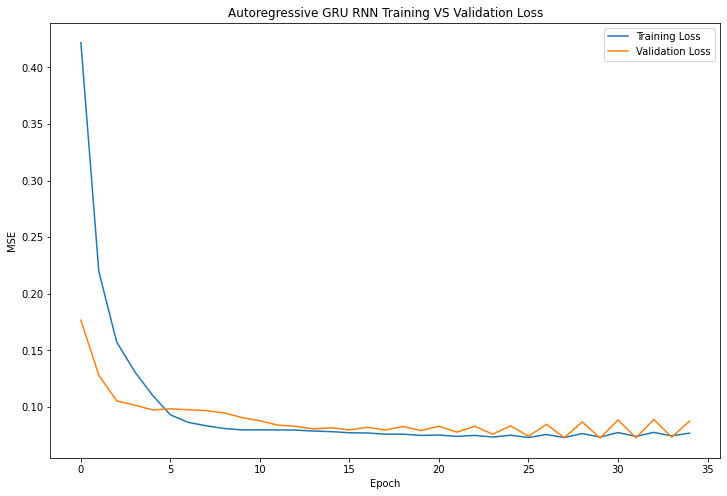

In [ ]:
ar_gru_history = compile_and_fit(ar_gru, ar_w, patience=5)
model_histories[ar_gru.model_name] = ar_gru_history
plot_training_history(ar_gru_history, ar_gru.model_name)

In [ ]:
ar_gru.summary()

Model: "ar_gru_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_cell_5 (GRUCell)        multiple                  3744      
                                                                 
 rnn_1 (RNN)                 multiple                  3744      
                                                                 
 dense_20 (Dense)            multiple                  165       
                                                                 
Total params: 3,909
Trainable params: 3,909
Non-trainable params: 0
_________________________________________________________________


#### Evaluation

6/6 [==============================] - 0s 7ms/step - loss: 0.0793


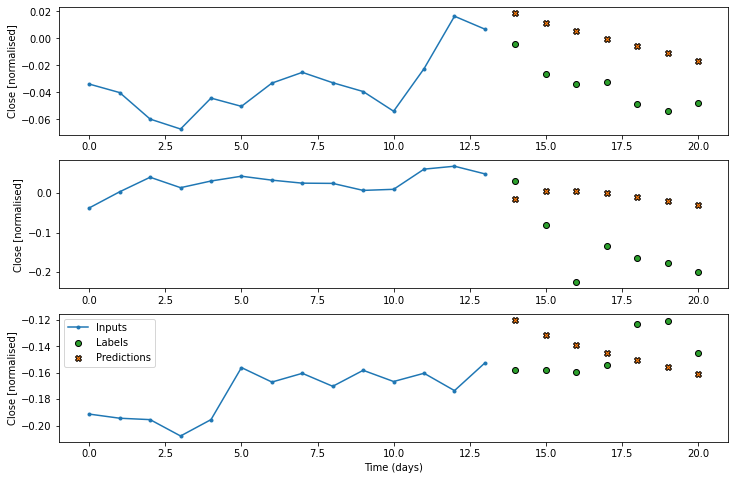

In [ ]:
training_performance[ar_gru.model_name] = ar_gru.evaluate(ar_w.training_dataset)
validation_performance[ar_gru.model_name] = ar_gru.evaluate(ar_w.validation_dataset)
testing_performance[ar_gru.model_name] = ar_gru.evaluate(ar_w.testing_dataset)
ar_w.plot(ar_gru)

### Training & Validation Loss Comparison

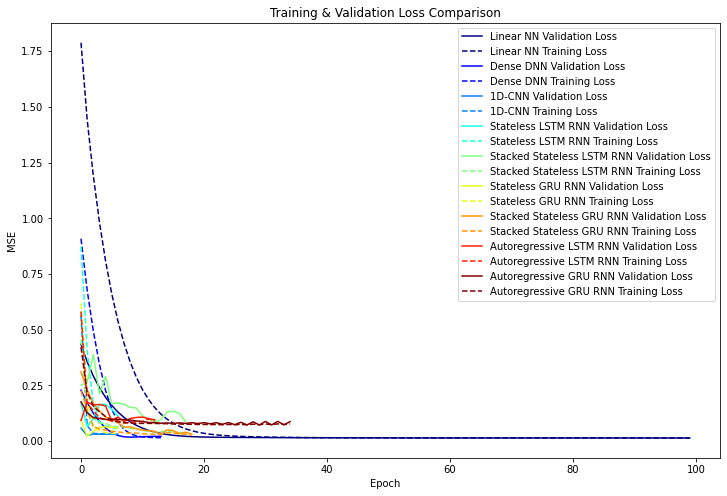

In [ ]:
plot_training_histories(model_histories)

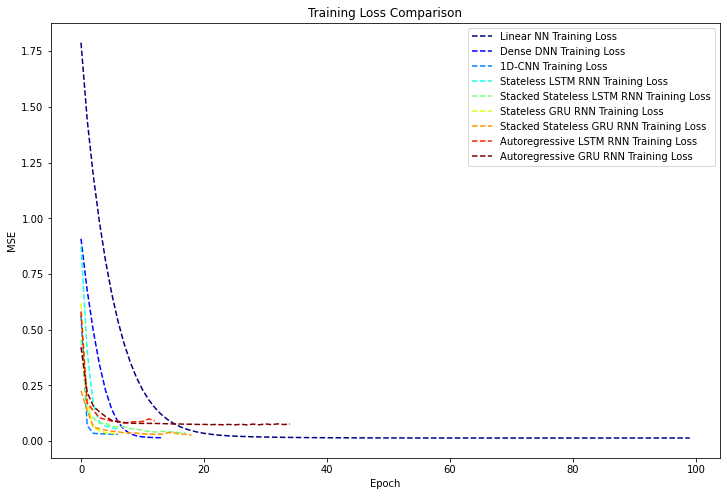

In [ ]:
plot_training_histories(model_histories,
                        validation=False)

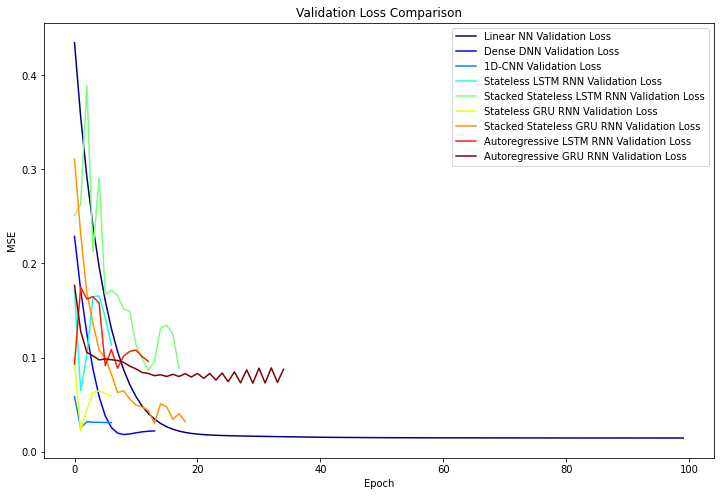

In [ ]:
plot_training_histories(model_histories,
                        training=False)

### Performance

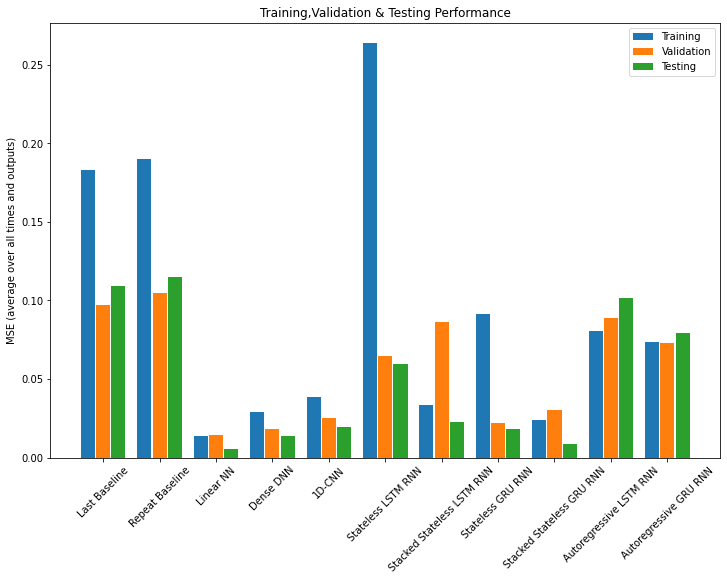

In [ ]:
plot_performance(validation_performance,
                 testing_performance,
                 training_performance=training_performance)

# 10. Prediction & Post-Processing

Now that we've explored all these different models, let's look at how to convert the raw model output from `tf.Tensor` back into a `pandas.DataFrame` for plotting.

The testing dataset contains daily price data from `'2022-03-30 00:00:00'` onwards. Since we are predicting based on the last 14 time steps, and each time step is a day, our predictions should start from `'2022-04-12 00:00:00'`.


These were the observed prices from the testing dataset.

In [ ]:
testing_df[['Close']]

,Close
Date,
2022-09-22 00:00:00+00:00,19413.550781
2022-09-23 00:00:00+00:00,19297.638672
2022-09-24 00:00:00+00:00,18937.011719
2022-09-25 00:00:00+00:00,18802.097656
2022-09-26 00:00:00+00:00,19222.671875
...,...
2023-03-19 00:00:00+00:00,28038.675781
2023-03-20 00:00:00+00:00,27767.236328
2023-03-21 00:00:00+00:00,28175.816406


# 11. Hyper-Parameter Tuning Using [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

If we want to perform hyper-parameter tuning, we need to construct a hypermodel i.e. a model architecture that defines its own hyper-parameter search space.

There's two types of hyper-parameters we can optimise:

* Model hyper-parameters: Influences model architecture, e.g. number of hidden layers, number of neurons/units in a layer, a layer's kernel/bias initialisers, the size of a convolution window, etc.
* Algorithm hyper-parameters: Influences the speed/quality of a learning algorithm, e.g. learning rate for stochastic gradient descent (SGD), which SGD algorithm to use (Adam, AdaGrad, RMSProp, etc.), batch size, even the loss function, etc.

We can use Keras Tuner to perform our search for optimal hyper-parameters on each model.

We can create a model builder function that returns a compiled model architecture using the **model hyper-parameter search space** you define.

(You could also subclass [`keras_tuner.HyperModel`](https://keras.io/api/keras_tuner/hypermodels/base_hypermodel/#hypermodel-class) and implement `def build(self, hp)` and override `fit(self, hp, model, *args, **kwargs`).

Before returning the model from the model builder function, we will delegate the compilation of the model to a separate function that defines the **algorithm hyper-parameter search space** (as this should be applied to every model in their respective hypermodel builder). This will return the compiled model so the model builder can return it.

We will hyper-parameter tune the stateless GRU RNN.

In [ ]:
def compile_model(model: tf.keras.Model,
                  hp: kt.HyperParameters):
    """
    Defines algorithm hyper-parameter search space for model compilation.

    :param model: un-built/un-compiled model.
    :param hp: kt.HyperParameters object for hyper-parameter search space.
    """
    # Tune the optimizer to use.
    hp_optimizer = hp.Choice('optimizer',
                             values=['sgd',
                                     'rmsprop',
                                     'adam',
                                     'nadam',
                                     'adadelta',
                                     'adagrad',
                                     'adamax',
                                     'ftrl'])

    # Tune the learning rate to use with the optimizer.
    hp_learning_rate = hp.Float('learning_rate',
                                min_value=1e-6,
                                max_value=1e-2,
                                step=10,
                                sampling='log')

    # Tune the loss function to use.
    hp_loss = hp.Choice('loss',
                        values=['mae',
                                'mse',
                                'msle'])

    model.compile(optimizer=tf.keras.optimizers.get(hp_optimizer,
                                                    learning_rate=hp_learning_rate),
                  loss=hp_loss)


def gru_builder(hp: kt.HyperParameters):
    """
    Stateless GRU RNN hypermodel builder
    """
    kt_gru = tf.keras.Sequential([
        # Tune number of neurons in the GRU RNN layer.
        tf.keras.layers.GRU(hp.Int('units',
                                   min_value=32,
                                   max_value=512,
                                   step=32),
                            dropout=0.1,  # Training regularisation
                            return_sequences=False),
        # Tune the kernel initialiser for the Dense layer.
        tf.keras.layers.Dense(LABEL_STEPS * N_LABEL_FEATURES,
                              kernel_initializer=hp.Choice('kernel_intializer',
                                                           values=['glorot_uniform',
                                                                   'he_uniform',
                                                                   'zeros'])),
        tf.keras.layers.Reshape([LABEL_STEPS, N_LABEL_FEATURES])
    ])
    kt_gru.model_name = 'Stateless GRU RNN'

    compile_model(kt_gru, hp)
    
    return kt_gru

Keras Tuner provides five tuners:

* `BayesianOptimization:` Builds a probability model of the objective function and uses it to select hyper-parameters that are most likely to score highly and evaluate them in the true objective function. [[Koehrsen's Explanation]](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f) [[Bayesian Optimization Primer, SIGOPT]](https://static.sigopt.com/b/20a144d208ef255d3b981ce419667ec25d8412e2/static/pdf/SigOpt_Bayesian_Optimization_Primer.pdf)
* `GridSearch:` Enumerates every hyper-parameter configuration in the hyper-parameter search space.
* `Hyperband:` Runs random configurations on a specific schedule of iterations per hyper-parameter configuration, using earlier results to select candidates for longer runs. [[FastML]](http://fastml.com/tuning-hyperparams-fast-with-hyperband/)
* `RandomSearch:` Performs `max_trials` iterations, where each iteration tries a random hyper-parameter configuration selected from the hyper-parameter search space.
* `Sklearn:` Not useful for us because it's only for Scikit-Learn models.

We'll use Hyperband.

> "The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 1 + logfactor(max_epochs) and rounding it up to the nearest integer." - [Introduction to the Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)



In [ ]:
tuner = kt.Hyperband(gru_builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3)

# Early stopping if validation loss doesn't fall after 5 epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  mode='min',
                                                  restore_best_weights=True)

tuner.search(w.training_dataset,
             epochs=MAX_EPOCHS * 3,
             validation_data=w.validation_dataset,
             callbacks=[early_stopping])

Trial 232 Complete [00h 00m 45s]
val_loss: 0.017653752118349075

Best val_loss So Far: 0.00981849990785122
Total elapsed time: 01h 10m 33s

Search: Running Trial #233

Value             |Best Value So Far |Hyperparameter
512               |448               |units
he_uniform        |he_uniform        |kernel_intializer
adamax            |adamax            |optimizer
0.001             |0.001             |learning_rate
mse               |msle              |loss
34                |4                 |tuner/epochs
12                |2                 |tuner/initial_epoch
2                 |4                 |tuner/bracket
1                 |1                 |tuner/round
0216              |0093              |tuner/trial_id

Epoch 13/34
22/46 [=============>................] - ETA: 2s - loss: 0.0082

KeyboardInterrupt: ignored

In [ ]:
tuner.results_summary()

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.model_name = 'KT-Best GRU RNN'
w.plot(model=best_model)

In [ ]:
tuner.search_space_summary(extended=True)

Still not better than a linear model based on the last time step though, apparently.

In [ ]:
best_model.compile(loss='mse')
training_performance[best_model.model_name] = best_model.evaluate(w.training_dataset)
validation_performance[best_model.model_name] = best_model.evaluate(w.validation_dataset)
testing_performance[best_model.model_name] = best_model.evaluate(w.testing_dataset)
plot_performance(validation_performance,
                 testing_performance,
                 training_performance=training_performance)

[How to reload the tuner if the Colaboratory runtime gets wiped out](https://stackoverflow.com/a/71143022)

In [ ]:
# Leaving a Grid Search tuner overnight
gs_tuner = kt.GridSearch(hypermodel=gru_builder,
                         objective=['loss', 'val_loss'],
                         directory='./drive/MyDrive',
                         overwrite=False,
                         project_name='keras_tuner_gru_rnn_hp_gridsearch')

# Early stopping if validation loss doesn't fall after 5 epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  mode='min',
                                                  restore_best_weights=True)

tuner.search(w.training_dataset,
             epochs=MAX_EPOCHS,
             validation_data=w.validation_dataset,
             callbacks=[early_stopping])

# 12. [Saving & Loading A Model](https://www.tensorflow.org/tutorials/keras/save_and_load)

## Saving Using Default `SavedModel` TF2.x Format

Consists of a directory containing protobuf binary files and a TensorFlow checkpoint.

In [ ]:
!mkdir -p tf_models/linear
!ls -la

In [ ]:
linear.save('tf_models/linear/btc_vs_usd')

## Loading `SavedModel` From File System

In [ ]:
!ls -la tf_models

In [ ]:
!ls -la tf_models/btc_vs_usd

In [ ]:
restored_model = tf.keras.models.load_model('tf_models/btc_vs_usd')
restored_model.summary()